# Analysis of ***Number of tumour cells killed per NK cell*** with mathematical modelling and Bayesian Inference

### Mathematical Model

Over an observation window of duration $T$, each NK cell kills targets at rate $r$ (kills per unit time).
The expected number of kills per cell during $T$ is $\lambda = r \cdot T$.

For each cell:

$$
N \sim \mathrm{Poisson}(\lambda), \qquad
\Pr(N = k \,|\, \lambda) = e^{-\lambda} \frac{\lambda^k}{k!}
$$

#### Replicate as a Histogram (Multinomial Likelihood)

Suppose we observe $M$ NK cells in one replicate. Let $K_k$ be the number of NK cells that killed exactly $k$ targets. Then:

$$
\sum_{k=0}^{\infty} K_k = M, \qquad
\mathbf{K} = (K_0, K_1, \dots) \sim \mathrm{Multinomial}\left(M, \mathbf{p}(\lambda)\right)
$$

where the category probabilities are:

$$
p_k(\lambda) = \Pr(N = k \,|\, \lambda) = e^{-\lambda} \frac{\lambda^k}{k!}
$$

> **Why Multinomial, not many Binomials?**
> The counts $K_k$ are **not independent** across $k$; they are jointly Multinomial given $M$ and $\lambda$. Fitting separate Binomials would double-count information.

In [1]:
import os
from pathlib import Path
from collections import defaultdict
import csv
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import MultipleLocator, MaxNLocator
import seaborn as sns
from scipy.stats import poisson
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.tensor.special import gammaln  # << use this

plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "legend.fontsize": 12,
    "legend.title_fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 18,
})
mpl.rcParams['animation.embed_limit'] = 2000

## 1. Import the experimental data here.

The total interaction killing duration is set as 3 hours, but this is just to calculate the exact value of the ***killing rates (No of tumour cells killed per NK cell per hour)***, it won't affect the interpretation of the results.

In [2]:
T_Total = 12

In [43]:
non_interaction = [
    # n=38: No interaction
    *[np.array([]) for _ in range(38)],
]

# No kill
no_kill = [
    # n=23: 1 contact, no kill
    *[np.array([0]) for _ in range(23)],
    # n=13: 2 contacts, no kill
    *[np.array([0, 0]) for _ in range(13)],
    # n=10: 3 contacts, no kill
    *[np.array([0, 0, 0]) for _ in range(10)],
    # n=2: 4 contacts, no kill
    *[np.array([0, 0, 0, 0]) for _ in range(2)],
    # n=1: 5 contacts, no kill
    *[np.array([0, 0, 0, 0, 0]) for _ in range(1)],
    # n=1: 6 contacts, no kill
    *[np.array([0, 0, 0, 0, 0, 0]) for _ in range(1)]
]

# Kill
kill = [
    # n=14: 1 contact, kill
    *[np.array([1]) for _ in range(14)],
    # n=15: 2 contacts, kill
    *[np.array([1, 1]) for _ in range(15)],
    # n=13: 3 contacts, kill
    *[np.array([1, 1, 1]) for _ in range(13)],
    # n=5: 4 contacts, kill
    *[np.array([1, 1, 1, 1]) for _ in range(5)],
    # n=3: 5 contacts, kill
    *[np.array([1, 1, 1, 1, 1]) for _ in range(3)],
    # n=3: 6 contacts, kill
    *[np.array([1, 1, 1, 1, 1, 1]) for _ in range(3)],
    # n=1: 7 contacts, kill
    *[np.array([1, 1, 1, 1, 1, 1, 1]) for _ in range(1)]
]

# Exhausted
exhausted = [
    *[np.array([1, 0]) for _ in range(7)],
    *[np.array([1, 0, 0]) for _ in range(1)],
    *[np.array([1, 1, 0]) for _ in range(9)],
    *[np.array([1, 0, 0, 0]) for _ in range(2)],
    *[np.array([1, 1, 0, 0]) for _ in range(1)],
    *[np.array([1, 1, 1, 0]) for _ in range(1)],
    *[np.array([1, 1, 0, 0, 0]) for _ in range(1)],
    *[np.array([1, 1, 1, 0, 0]) for _ in range(3)],
    *[np.array([1, 1, 1, 1, 0]) for _ in range(1)],
    *[np.array([1, 0, 0, 0, 0, 0]) for _ in range(1)],
    *[np.array([1, 1, 1, 1, 1, 0]) for _ in range(2)],
    *[np.array([1, 1, 1, 1, 1, 1, 1, 0]) for _ in range(1)],
]

# Stochastic
stochastic = [
    # n=1
    *[np.array([0, 1, 1, 0]) for _ in range(1)],
    # n=1
    *[np.array([1, 0, 1, 0]) for _ in range(1)],
    # n=1
    *[np.array([1, 1, 0, 1, 0]) for _ in range(1)],
    # n=1
    *[np.array([1, 0, 1, 0, 0, 0]) for _ in range(1)],
    # n=1
    *[np.array([0, 0, 0, 1, 1, 1]) for _ in range(1)],
    # n=1
    *[np.array([0, 1, 1, 0, 0, 0, 0]) for _ in range(1)],
]

# all_history = non_interaction + no_kill + kill + exhausted + stochastic
all_history = no_kill + kill + exhausted + stochastic
print(f"Total number of histories represented: {len(all_history)}")

all_cell_killNo = [int(np.sum(cell)) for cell in all_history]
kill_counts = np.array(all_cell_killNo)
np.random.shuffle(kill_counts)
replicates = np.array_split(kill_counts, 4)

KillFreqTable = {
    'No treatment': {}
}
for i, rep in enumerate(replicates):
    KillFreqTable['No treatment'][i+1] = rep
    print(f"Replicate {i+1} (size: {len(rep)}):")
    print(rep)
    print()
    
KillFreqTable

Total number of histories represented: 140
Replicate 1 (size: 35):
[0 1 1 1 0 6 2 0 1 4 2 2 5 0 0 1 0 0 2 3 2 0 3 2 2 3 1 2 0 1 1 2 2 1 2]

Replicate 2 (size: 35):
[0 0 5 0 2 3 3 1 0 0 4 2 0 2 1 0 1 0 0 0 0 1 3 0 0 2 0 2 0 3 0 0 1 0 5]

Replicate 3 (size: 35):
[2 7 3 0 1 2 3 3 3 6 0 3 0 2 0 1 2 3 2 4 0 4 1 1 3 3 0 1 0 6 4 0 4 0 0]

Replicate 4 (size: 35):
[0 0 1 3 1 2 0 0 5 5 0 2 2 2 3 0 1 7 3 1 0 0 2 2 1 0 1 2 2 0 0 0 0 3 2]



{'No treatment': {1: array([0, 1, 1, 1, 0, 6, 2, 0, 1, 4, 2, 2, 5, 0, 0, 1, 0, 0, 2, 3, 2, 0,
         3, 2, 2, 3, 1, 2, 0, 1, 1, 2, 2, 1, 2]),
  2: array([0, 0, 5, 0, 2, 3, 3, 1, 0, 0, 4, 2, 0, 2, 1, 0, 1, 0, 0, 0, 0, 1,
         3, 0, 0, 2, 0, 2, 0, 3, 0, 0, 1, 0, 5]),
  3: array([2, 7, 3, 0, 1, 2, 3, 3, 3, 6, 0, 3, 0, 2, 0, 1, 2, 3, 2, 4, 0, 4,
         1, 1, 3, 3, 0, 1, 0, 6, 4, 0, 4, 0, 0]),
  4: array([0, 0, 1, 3, 1, 2, 0, 0, 5, 5, 0, 2, 2, 2, 3, 0, 1, 7, 3, 1, 0, 0,
         2, 2, 1, 0, 1, 2, 2, 0, 0, 0, 0, 3, 2])}}

**Visualisation of the Experimental Data**

There are two main types of figures used:

1. *Individual Replicates*: Plot each replicate separately to show variability, then plot the mean across all replicates for each condition.
2. *Mean and Variation*: Plot the mean and standard deviation as a line with a shaded band to illustrate the central tendency and spread.


/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_46126/1806390812.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('YlGnBu')


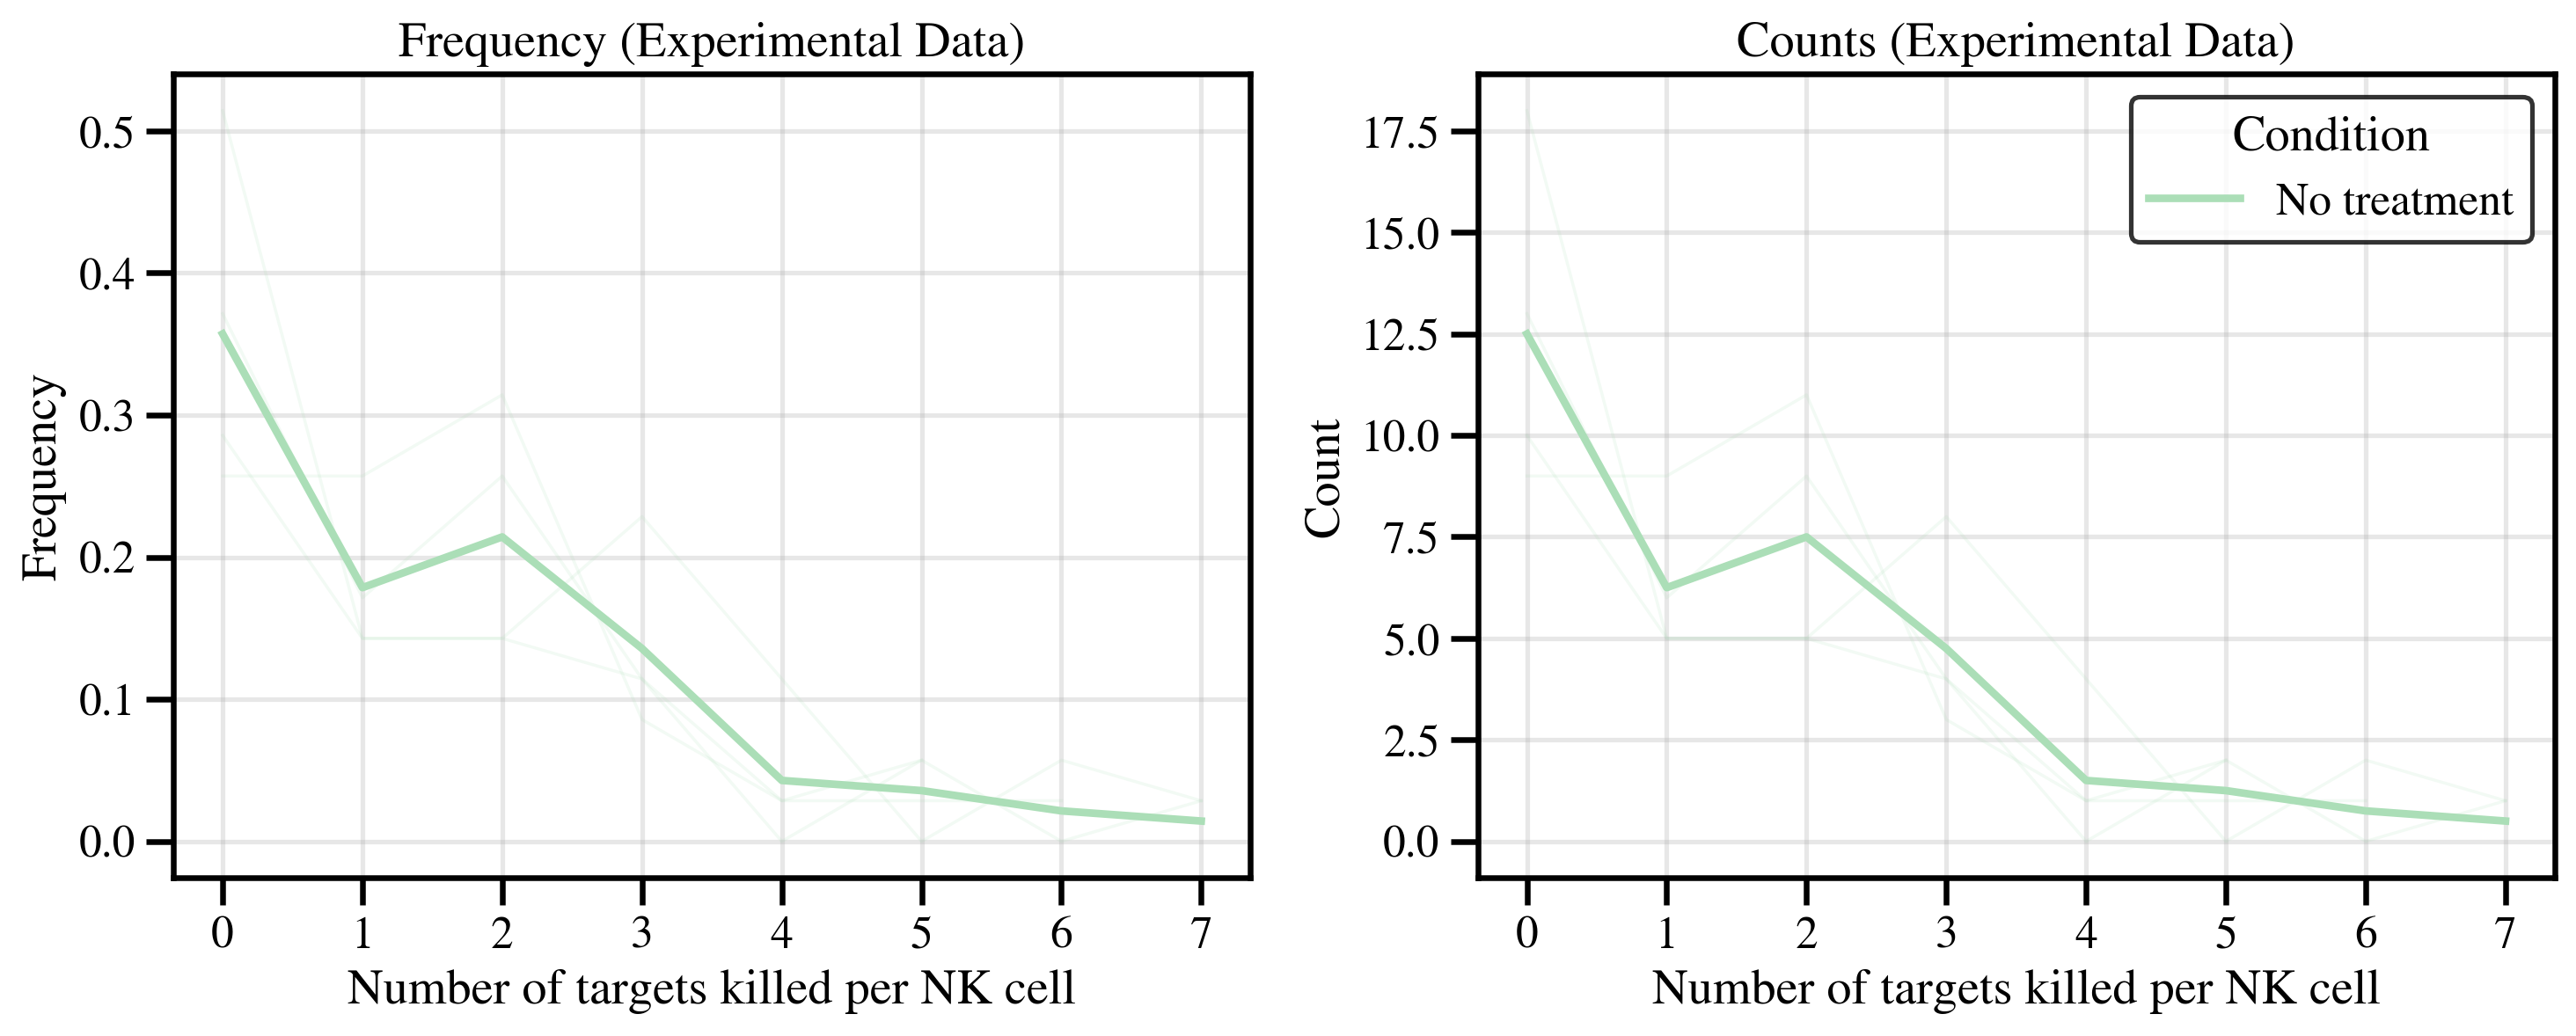

In [44]:
# Plotting real experimental data from KillFreqTable
conditions = list(KillFreqTable.keys())
dates = sorted({date for cond in KillFreqTable.values() for date in cond.keys()})
cmap = get_cmap('YlGnBu')
colors = cmap(np.linspace(0.3, 0.9, len(conditions)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=250, sharex=True)
ax_freq, ax_count = axes

for i, cond in enumerate(conditions):
    colour = colors[i]
    counts_all, freqs_all = [], []
    k_max = 0
    for date in dates:
        arr = KillFreqTable[cond].get(date, np.array([]))
        if arr.size == 0:
            continue
        k_max = max(k_max, arr.max())
        n_cells = arr.size
        counts = np.bincount(arr, minlength=int(arr.max())+1)
        freq = counts / n_cells if n_cells > 0 else np.zeros_like(counts)
        counts_all.append(counts)
        freqs_all.append(freq)
        ax_freq.plot(np.arange(len(freq)), freq, alpha=0.15, color=colour, linewidth=1)
        ax_count.plot(np.arange(len(counts)), counts, alpha=0.15, color=colour, linewidth=1)
    if freqs_all:
        maxlen = max(len(f) for f in freqs_all)
        freqs_all_pad = [np.pad(f, (0, maxlen - len(f)), 'constant') for f in freqs_all]
        counts_all_pad = [np.pad(c, (0, maxlen - len(c)), 'constant') for c in counts_all]
        freqs_mean = np.mean(np.vstack(freqs_all_pad), axis=0)
        counts_mean = np.mean(np.vstack(counts_all_pad), axis=0)
        ax_freq.plot(np.arange(maxlen), freqs_mean, color=colour, linewidth=2.5, label=cond)
        ax_count.plot(np.arange(maxlen), counts_mean, color=colour, linewidth=2.5, label=cond)

ax_freq.set_title("Frequency (Experimental Data)")
ax_count.set_title("Counts (Experimental Data)")
ax_freq.set_ylabel("Frequency")
ax_count.set_ylabel("Count")
for ax in (ax_freq, ax_count):
    ax.set_xlabel("Number of targets killed per NK cell")
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.grid(True, alpha=0.3)

ax_count.legend(title = "Condition", frameon=True, edgecolor='black', loc='upper right')
plt.tight_layout()
plt.savefig("./experimental_data_plots_individual.pdf", dpi=500, bbox_inches="tight")
plt.show()

/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_46126/392302644.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('YlGnBu')


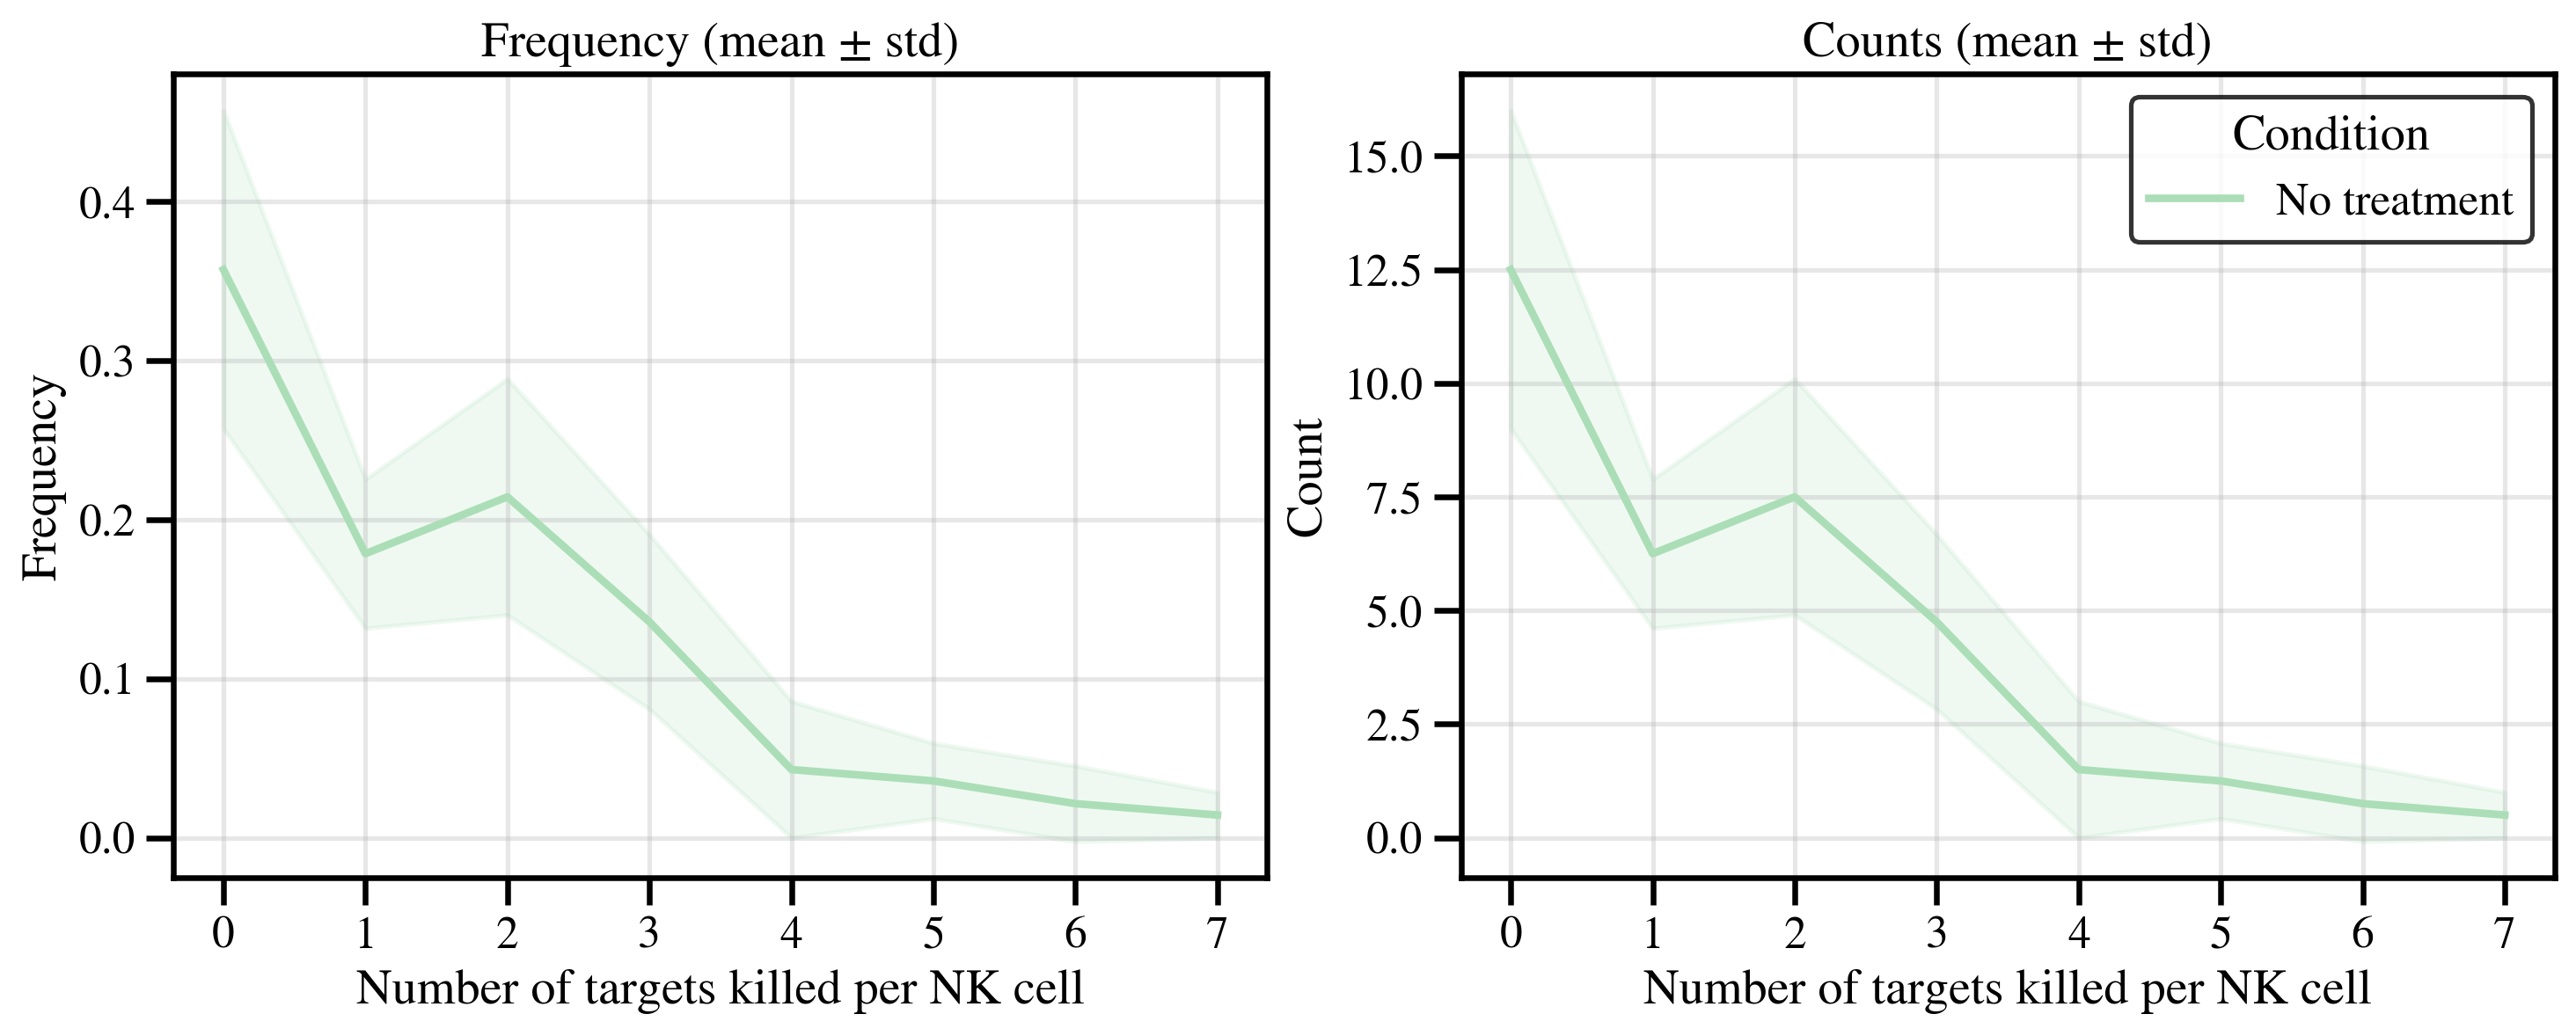

In [45]:
conditions = list(KillFreqTable.keys())
dates = sorted({date for cond in KillFreqTable.values() for date in cond.keys()})
cmap = get_cmap('YlGnBu')
colors = cmap(np.linspace(0.3, 0.9, len(conditions)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=250, sharex=True)
ax_freq, ax_count = axes

for i, cond in enumerate(conditions):
    colour = colors[i]
    freqs_all, counts_all = [], []
    maxlen = 0
    # Collect all replicates for this condition
    for date in dates:
        arr = KillFreqTable[cond].get(date, np.array([]))
        if arr.size == 0:
            continue
        n_cells = arr.size
        counts = np.bincount(arr, minlength=int(arr.max())+1)
        freq = counts / n_cells if n_cells > 0 else np.zeros_like(counts)
        counts_all.append(counts)
        freqs_all.append(freq)
        maxlen = max(maxlen, len(counts))
    # Pad arrays to same length
    if freqs_all:
        freqs_all_pad = [np.pad(f, (0, maxlen - len(f)), 'constant') for f in freqs_all]
        counts_all_pad = [np.pad(c, (0, maxlen - len(c)), 'constant') for c in counts_all]
        freqs_all_pad = np.vstack(freqs_all_pad)
        counts_all_pad = np.vstack(counts_all_pad)
        freqs_mean = np.mean(freqs_all_pad, axis=0)
        freqs_std = np.std(freqs_all_pad, axis=0)
        counts_mean = np.mean(counts_all_pad, axis=0)
        counts_std = np.std(counts_all_pad, axis=0)
        x = np.arange(maxlen)
        # Frequency plot: mean line + std band
        ax_freq.plot(x, freqs_mean, color=colour, linewidth=2.5, label=cond)
        ax_freq.fill_between(x, freqs_mean - freqs_std, freqs_mean + freqs_std, color=colour, alpha=0.18)
        # Count plot: mean line + std band
        ax_count.plot(x, counts_mean, color=colour, linewidth=2.5, label=cond)
        ax_count.fill_between(x, counts_mean - counts_std, counts_mean + counts_std, color=colour, alpha=0.18)

ax_freq.set_title("Frequency (mean ± std)")
ax_count.set_title("Counts (mean ± std)")
ax_freq.set_ylabel("Frequency")
ax_count.set_ylabel("Count")
for ax in (ax_freq, ax_count):
    ax.set_xlabel("Number of targets killed per NK cell")
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.grid(True, alpha=0.3)

ax_count.legend(title = "Condition", frameon=True, edgecolor='black', loc='upper right')
plt.tight_layout()
plt.savefig("./experimental_data_plots_combine.pdf", dpi=500, bbox_inches="tight")
plt.show()

**Here is the experimental metadata**

In [46]:
for _, group in enumerate(KillFreqTable):
    print("Experimental condition: ", group)
    print("replicates: ", list(KillFreqTable[group].keys()))
    each_replicate = [len(KillFreqTable[group][rep]) for rep in KillFreqTable[group].keys()]
    print("Cell number in each replicate: ", each_replicate, "\n")


Experimental condition:  No treatment
replicates:  [1, 2, 3, 4]
Cell number in each replicate:  [35, 35, 35, 35] 



## 2. Bayesian Inference and the comparison between the posterior prediction and experimental data

This analysis involves two main steps:

1. **Estimate Killing Rates:**
   - Apply Bayesian inference to the experimental data to estimate the killing rate ($r$) for each condition.

2. **Posterior Prediction:**
   - Use the estimated posterior rates to predict the likely frequency distribution for the number of tumour cells killed per NK cell.
   - Compare these predictions (posterior bands) directly to the observed experimental frequencies for validation.

**Run Markov chain Monte Carlo algorithm here**

In [27]:
def inference(experimental_data, T=60.0, draws=3000, tune=3000, chains=4, seed=66):
    """
    experimental_data: list of 1-D arrays (replicates), each holding per-cell kill counts
    returns: ArviZ InferenceData
    """
    # flatten per-cell counts across replicates
    all_cells = np.concatenate([np.asarray(rep, int) for rep in experimental_data if len(rep) > 0])
    # bins 0..Kcut-2 explicitly, tail bin at Kcut-1
    Kcut = int(all_cells.max()) + 3
    K = np.bincount(np.clip(all_cells, 0, Kcut - 1), minlength=Kcut).astype("int64")
    M = int(K.sum())
    
    # MCMC
    with pm.Model() as model:
        # prior on log10(lambda)
        eta = pm.Uniform("eta", lower=-10.0, upper=10.0)     # eta = log10(lambda)
        lam = pm.Deterministic("lam", 10.0 ** eta)
        r   = pm.Deterministic("r", lam / T)               # per-time rate

        # Poisson pmf for categories 0..Kcut-2 (log-space)
        ks = pt.arange(Kcut - 1)
        logpmf = -lam + ks * pt.log(lam) - gammaln(ks + 1)
        pmf = pt.exp(logpmf)

        # tail (>= Kcut-1), clip + renormalise just in case
        tail = 1.0 - pt.sum(pmf)
        pmf  = pt.clip(pmf, 1e-16, 1.0)
        tail = pt.clip(tail, 1e-16, 1.0)
        probs = pt.concatenate([pmf, tail[None]])
        probs = probs / pt.sum(probs)

        pm.Multinomial("K", n=M, p=probs, observed=K)

        idata = pm.sample(
            draws=draws, tune=tune, chains=chains,
            target_accept=0.9, random_seed=seed, progressbar=True)

        # attach log_likelihood (handy for plotting colour scales etc.)
        try:
            idata = pm.compute_log_likelihood(idata, extend_inferencedata=True)
        except Exception:
            pass

    return idata


def run_inference_for_list(data_list, T=60.0, labels=None, seed0=42):
    """
    data_list: list where each item is `experimental_data` (list of 1-D arrays per replicate)
    returns: list of (label, idata), where idata is the InferenceData from `inference(...)`.
    """
    if labels is None:
        labels = [f"cond_{i}" for i in range(len(data_list))]

    out = []
    for i, experimental_data in enumerate(data_list):
        lbl = str(labels[i])
        print(f"Fitting {lbl} ...")
        idata = inference(experimental_data, T=T, seed=seed0 + i)
        # Save the inference data
        idata.to_netcdf(f"{lbl}_idata.nc")
        out.append((lbl, idata))
    return out


# Prepare data_list and labels for real experimental data
labels = list(KillFreqTable.keys())
data_list = [
    [KillFreqTable[cond][rep] for rep in KillFreqTable[cond].keys()]
    for cond in labels
]
# Run Bayesian inference for each experimental condition
idatas = run_inference_for_list(data_list, T=T_Total, labels=labels)

Initializing NUTS using jitter+adapt_diag...


Fitting No treatment ...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 1 seconds.


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

**visualise the estimated posterior rates**

No treatment: mean = 0.105, HDI = [0.0912, 0.118]
Saved PDF: ./rate_posteriors_facet.pdf


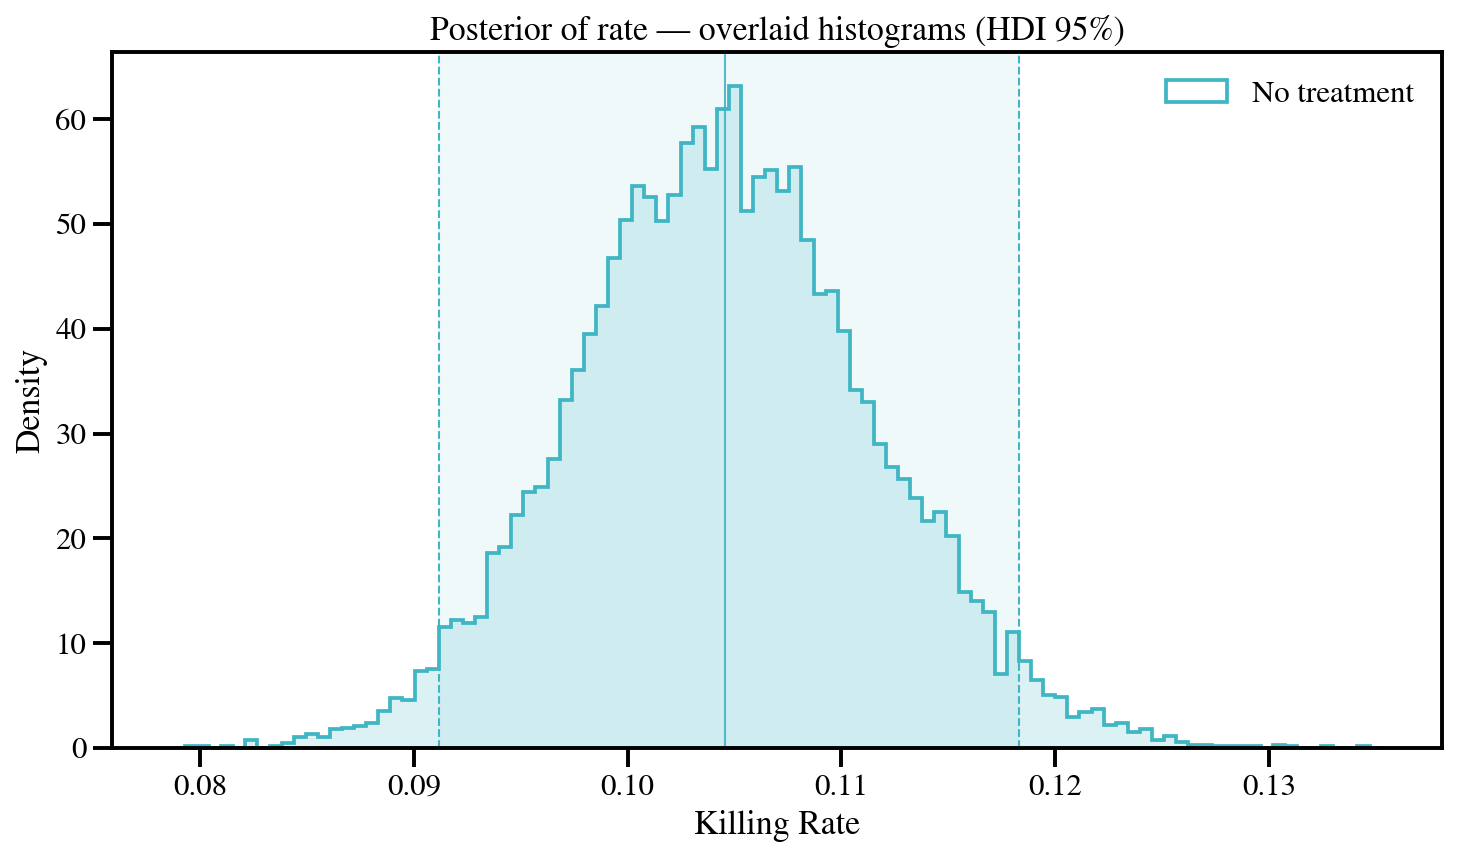

No treatment: mean = 0.105, HDI = [0.0912, 0.118]
Saved PDF: ./rate_posteriors_kde.pdf


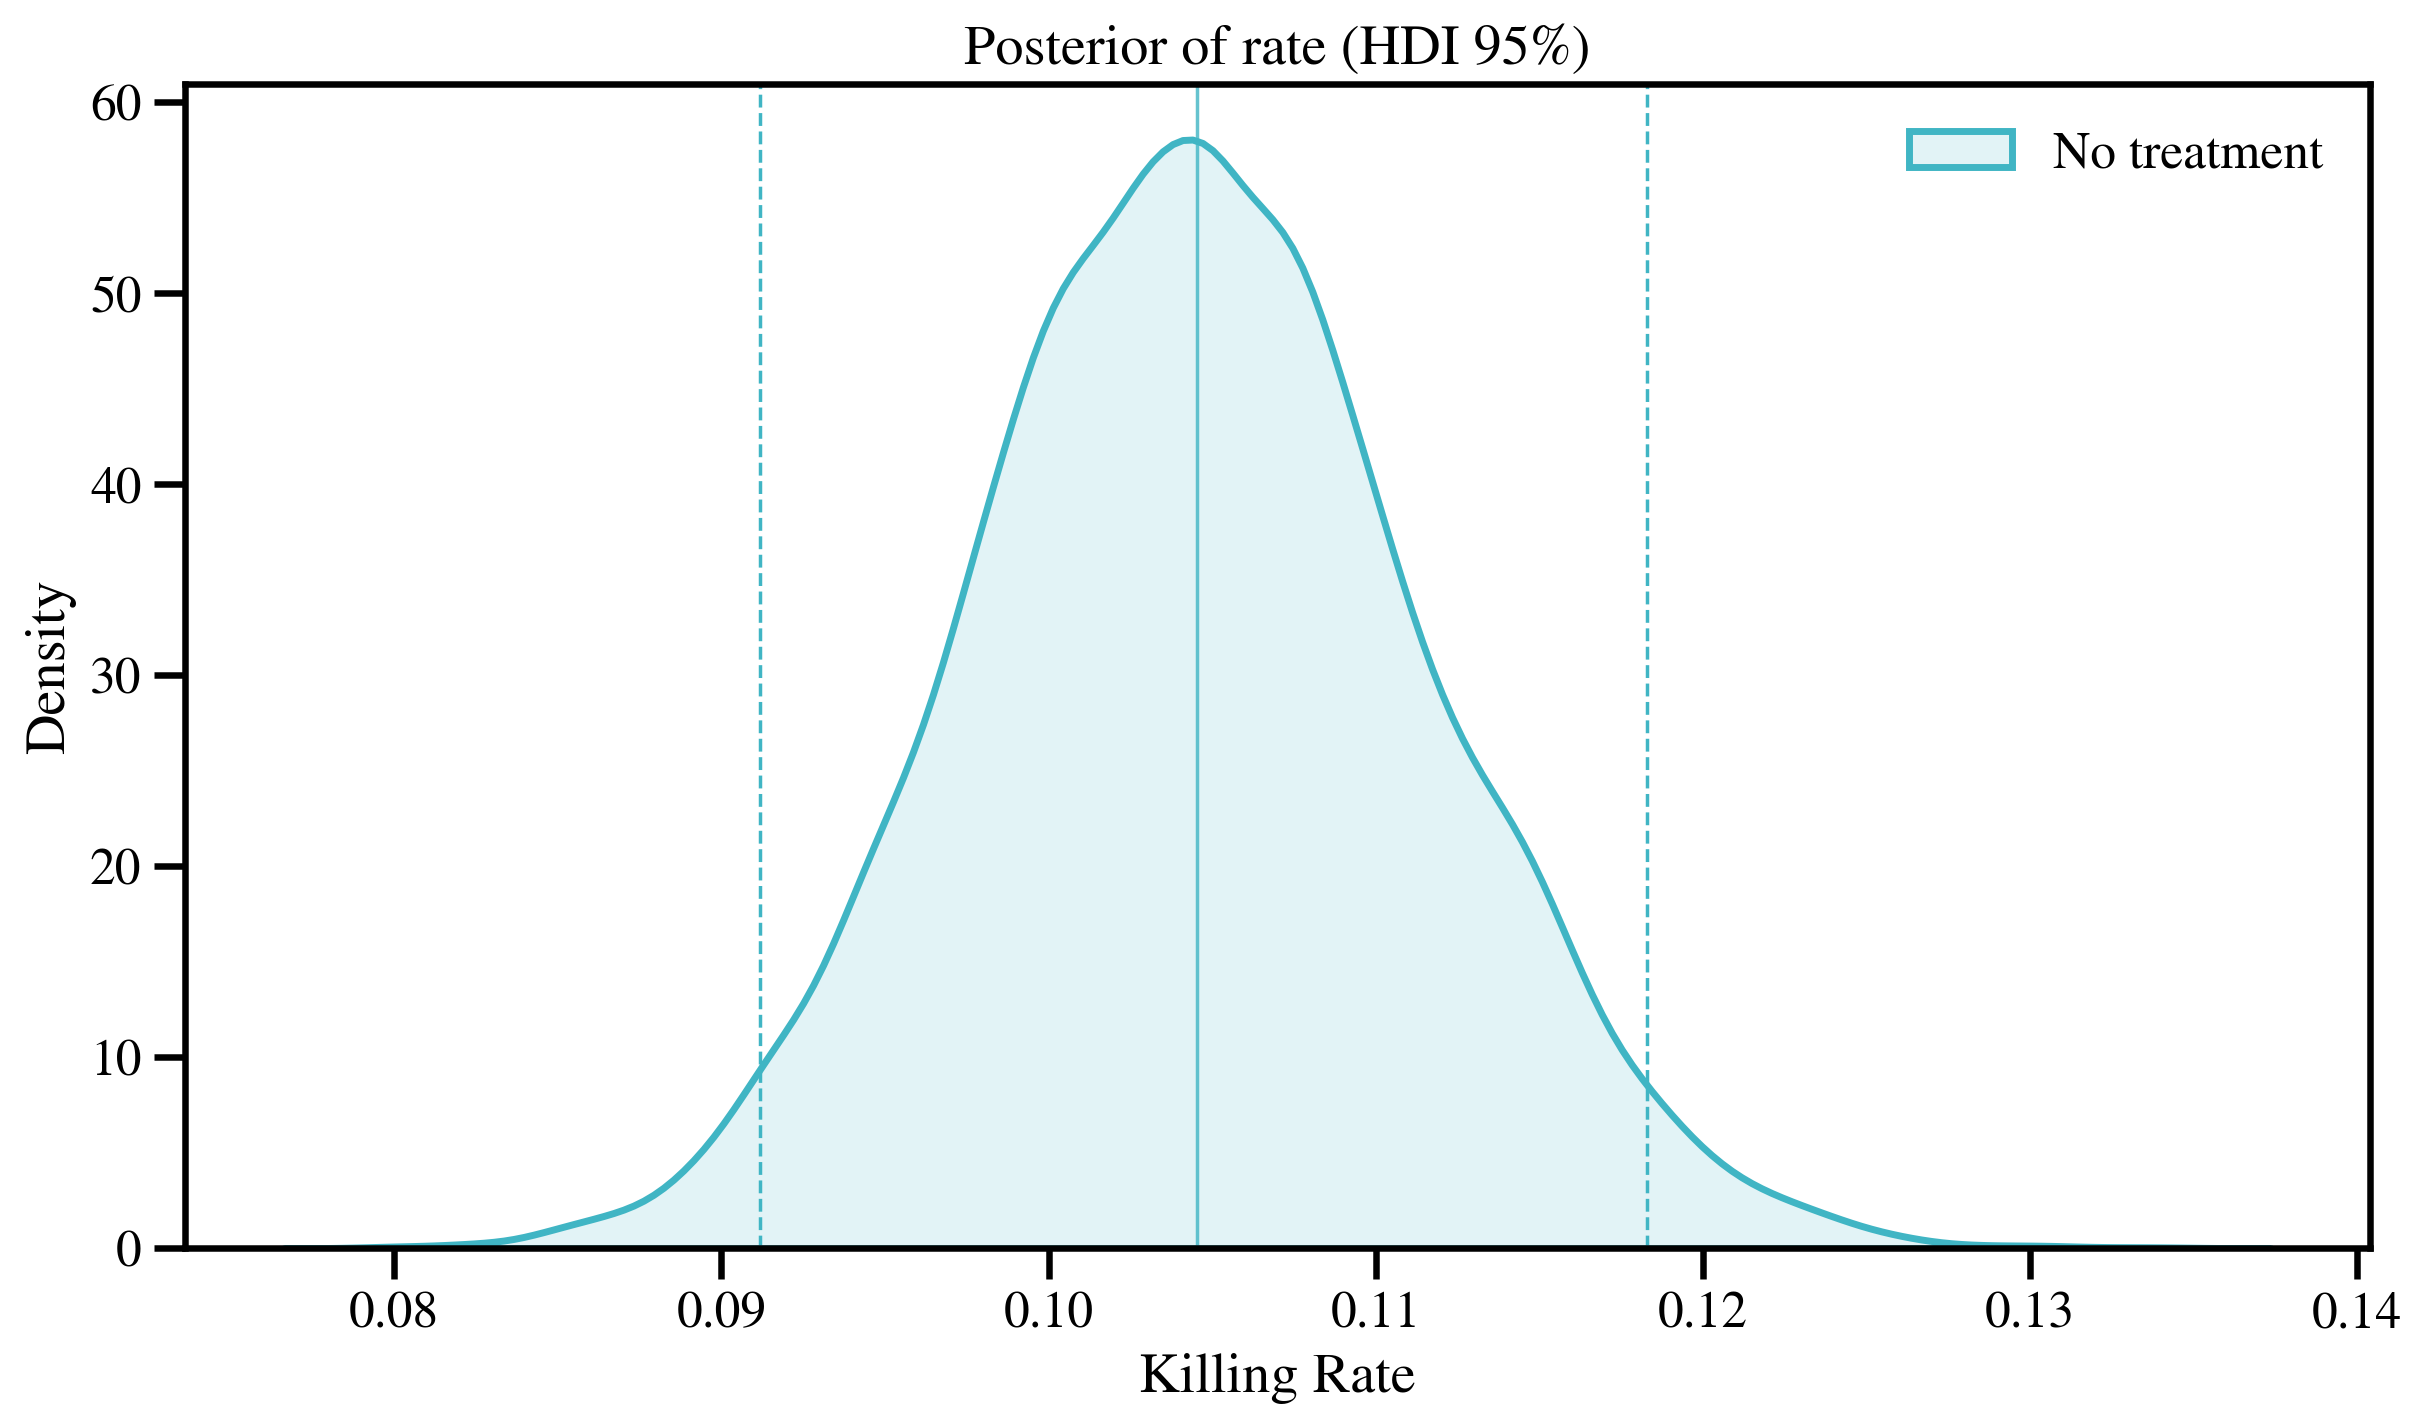

In [28]:
def plot_rate_posteriors(
    idatas,
    style="kde",              # "kde" or "hist" (overlayed in ONE diagram)
    hdi_prob=0.95,
    export_pdf=False,
    pdf_path="rate_posteriors.pdf",
    bins=100,
    density=False,            # True=normalised density; False=counts
    show_mean=True,
    legend_show_mean=True,    # <-- put posterior mean in legend text
    legend_fmt=".3g",         # <-- format for the mean in legend
    legend_loc="best",        # <-- where to place the legend
):
    """
    idatas: list of (label, idata) as returned by run_inference_for_list()
    style : "kde" for overlaid density curves; "hist" for overlaid histograms on ONE axis
    """
    # Collect posterior draws of r into a tidy DataFrame
    frames, order = [], []
    for label, idata in idatas:
        r_da = idata.posterior["r"]  # dims ('chain','draw')
        r_vals = r_da.stack(sample=("chain", "draw")).values.astype(float).ravel()
        frames.append(pd.DataFrame({"r": r_vals, "label": label}))
        order.append(label)
    all_df = pd.concat(frames, ignore_index=True)

    # HDIs & posterior means per label
    hdi_map = {}
    mean_map = {}
    for lab in order:
        vals = all_df.loc[all_df["label"] == lab, "r"].to_numpy()
        hdi_map[lab] = tuple(az.hdi(vals, hdi_prob=hdi_prob))
        mean_map[lab] = float(np.mean(vals))
        print(f"{lab}: mean = {format(mean_map[lab], legend_fmt)}, HDI = [{format(hdi_map[lab][0], legend_fmt)}, {format(hdi_map[lab][1], legend_fmt)}]")

    # Helper to make legend text
    def _legend_label(lab):
        return lab

    sns.set_context("talk", font_scale=0.9)
    palette = sns.color_palette("YlGnBu", n_colors=len(order))

    if style.lower() == "kde":
        # -------- Overlaid KDEs --------
        fig, ax = plt.subplots(figsize=(10, 6), dpi=250)
        for c, lab in zip(palette, order):
            sdf = all_df.loc[all_df["label"] == lab]
            sns.kdeplot(data=sdf, x="r", ax=ax, linewidth=2, color=c,
                        label=_legend_label(lab), fill=True, alpha=0.15)
            lo, hi = hdi_map[lab]
            ax.axvline(lo, color=c, linestyle="--", linewidth=1)
            ax.axvline(hi, color=c, linestyle="--", linewidth=1)
            if show_mean:
                ax.axvline(mean_map[lab], color=c, linestyle="-", linewidth=1, alpha=0.8)

        ax.set_xlabel("Killing Rate")
        ax.set_ylabel("Density")
        ax.set_title(f"Posterior of rate (HDI {int(hdi_prob*100)}%)")
        ax.legend(frameon=False, loc=legend_loc)

    else:
        # -------- Overlaid histograms on ONE axis --------
        fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
        rmin, rmax = all_df["r"].min(), all_df["r"].max()
        span = (rmax - rmin) or 1e-6
        rmin, rmax = rmin - 0.02 * span, rmax + 0.02 * span
        edges = np.linspace(rmin, rmax, bins + 1)

        for c, lab in zip(palette, order):
            vals = all_df.loc[all_df["label"] == lab, "r"].to_numpy()
            # filled translucent + outline for readability
            ax.hist(vals, bins=edges, density=density, histtype="stepfilled",
                    alpha=0.18, color=c, label=None)
            ax.hist(vals, bins=edges, density=density, histtype="step",
                    linewidth=1.8, color=c, label=_legend_label(lab))

            # HDI shading and lines
            lo, hi = hdi_map[lab]
            ax.axvspan(lo, hi, color=c, alpha=0.08, linewidth=0)
            ax.axvline(lo, color=c, linestyle="--", linewidth=1)
            ax.axvline(hi, color=c, linestyle="--", linewidth=1)
            if show_mean:
                ax.axvline(mean_map[lab], color=c, linestyle="-", linewidth=1, alpha=0.9)

        ax.set_xlabel("Killing Rate")
        ax.set_ylabel("Density" if density else "Count")
        ax.set_title(f"Posterior of rate — overlaid histograms (HDI {int(hdi_prob*100)}%)")
        ax.legend(frameon=False, loc=legend_loc)

    plt.tight_layout()
    if export_pdf:
        fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
        print(f"Saved PDF: {pdf_path}")
    plt.show()
# Plot posterior distributions of the inferred rates
plot_rate_posteriors(
    idatas, style="facet", hdi_prob=0.95, density = True,
    export_pdf=True, pdf_path="./rate_posteriors_facet.pdf"
)
plot_rate_posteriors(
    idatas, style="kde", hdi_prob=0.95, density = True,
    export_pdf=True, pdf_path="./rate_posteriors_kde.pdf"
)

In [29]:
for i, (cond, idata_tuple) in enumerate(zip(KillFreqTable.keys(), idatas)):
    print(f"\n=== Experimental Condition: {cond} ===")
    replicates = list(KillFreqTable[cond].keys())
    print(f"Replicates: {replicates}")
    each_replicate = [len(KillFreqTable[cond][rep]) for rep in replicates]
    print(f"Cell number in each replicate: {each_replicate}")
    print(f"Total number: {sum(each_replicate)}")
    posterior_rates = idata_tuple[1].posterior['r'].values.flatten()
    print(f"Posterior rates (flattened):\n{posterior_rates}")


=== Experimental Condition: No treatment ===
Replicates: [1, 2, 3, 4, 5]
Cell number in each replicate: [36, 36, 36, 35, 35]
Total number: 178
Posterior rates (flattened):
[0.10376842 0.11225011 0.10610876 ... 0.10937104 0.10208995 0.11382028]


**Posterior prediction**

In [30]:
def experiment(
    killing_rate: float = 0.01,
    Duration: float = 60,
    Killer_cell_number: int = 50,
    replicate: int = 10,
    seed: int = 66,
):
    lam = killing_rate * Duration
    rng = np.random.default_rng(seed)
    kills = []
    for _ in range(replicate):
        kill = poisson.rvs(mu=lam, size=Killer_cell_number, random_state=rng)
        kills.append(kill)
    return kills


In [5]:
data_dir = "./sim_data_exports"
generated_data = {}

for fname in os.listdir(data_dir):
    if fname.endswith("_simdata.npz"):
        group = fname.replace("_simdata.npz", "").replace("_", " ")
        arrs = np.load(os.path.join(data_dir, fname), allow_pickle=True)
        exp_freqs = list(arrs['exp_freqs'])
        colour = arrs['colour']
        maxlen = int(arrs['maxlen'])
        # Collect all sim_freqs_per_rep_* arrays
        sim_freqs_per_rep = [arrs[key] for key in arrs.files if key.startswith("sim_freqs_per_rep_")]
        generated_data[group] = {
            'exp_freqs': exp_freqs,
            'sim_freqs_per_rep': sim_freqs_per_rep,
            'colour': colour,
            'maxlen': maxlen
        }

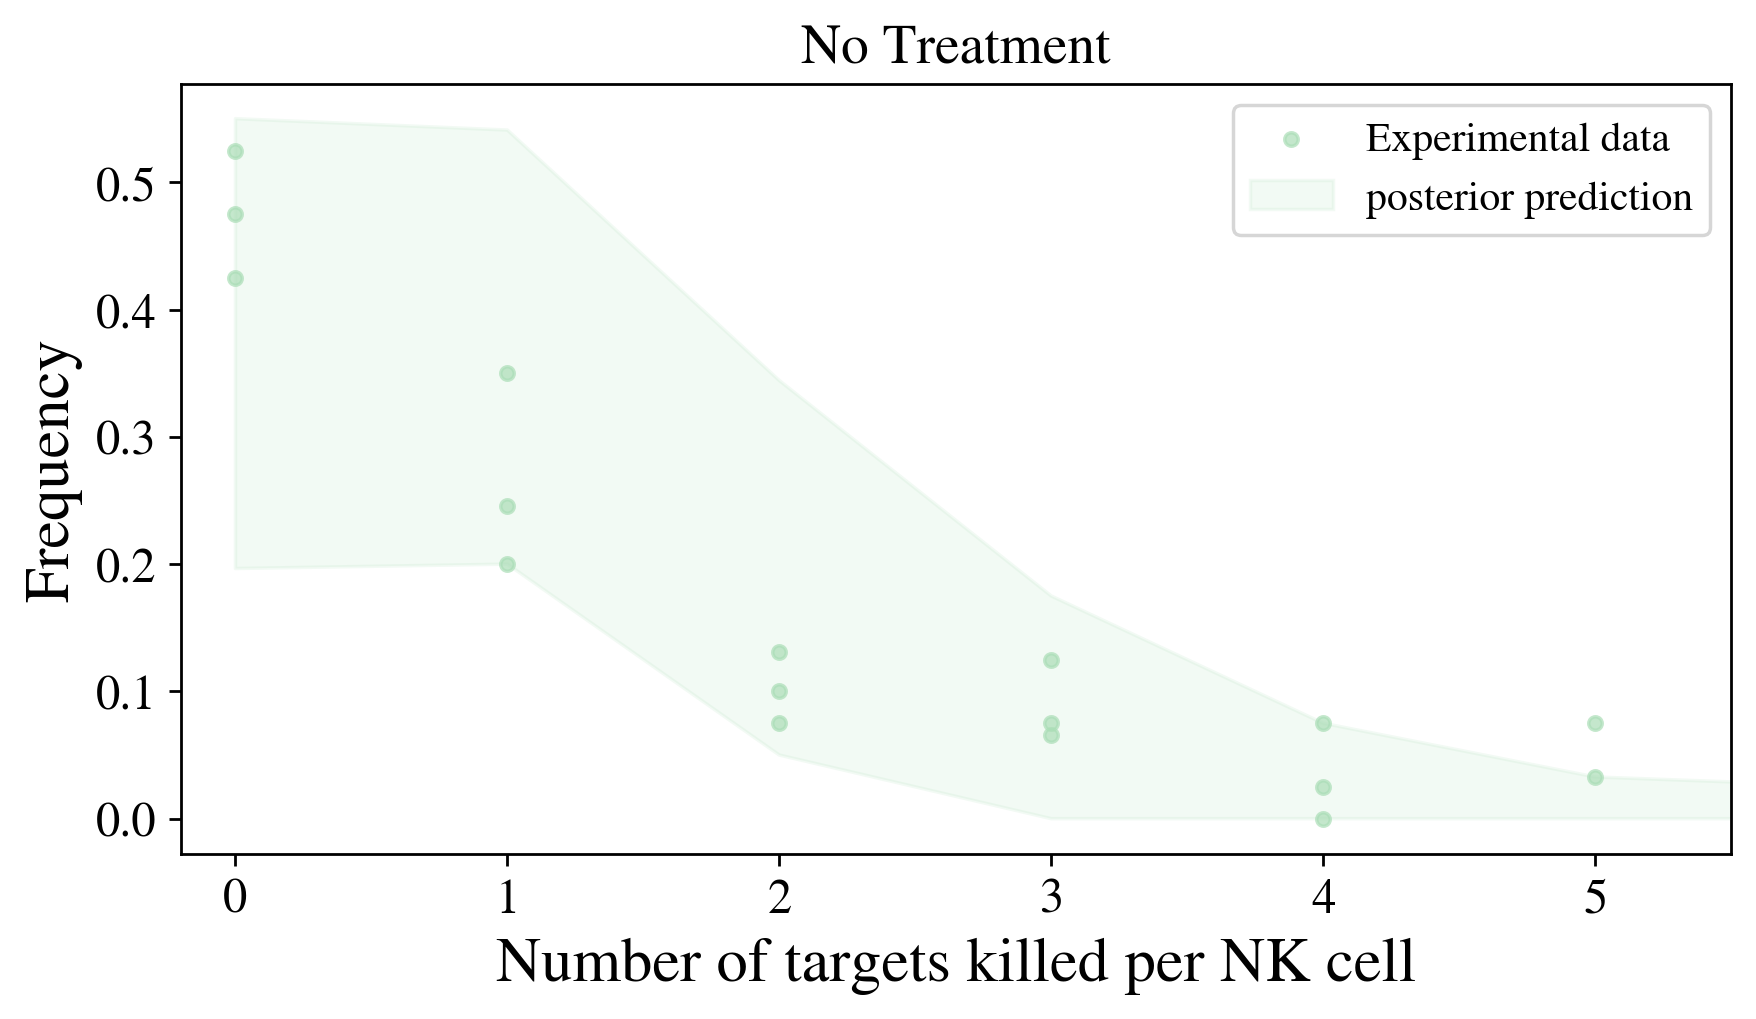

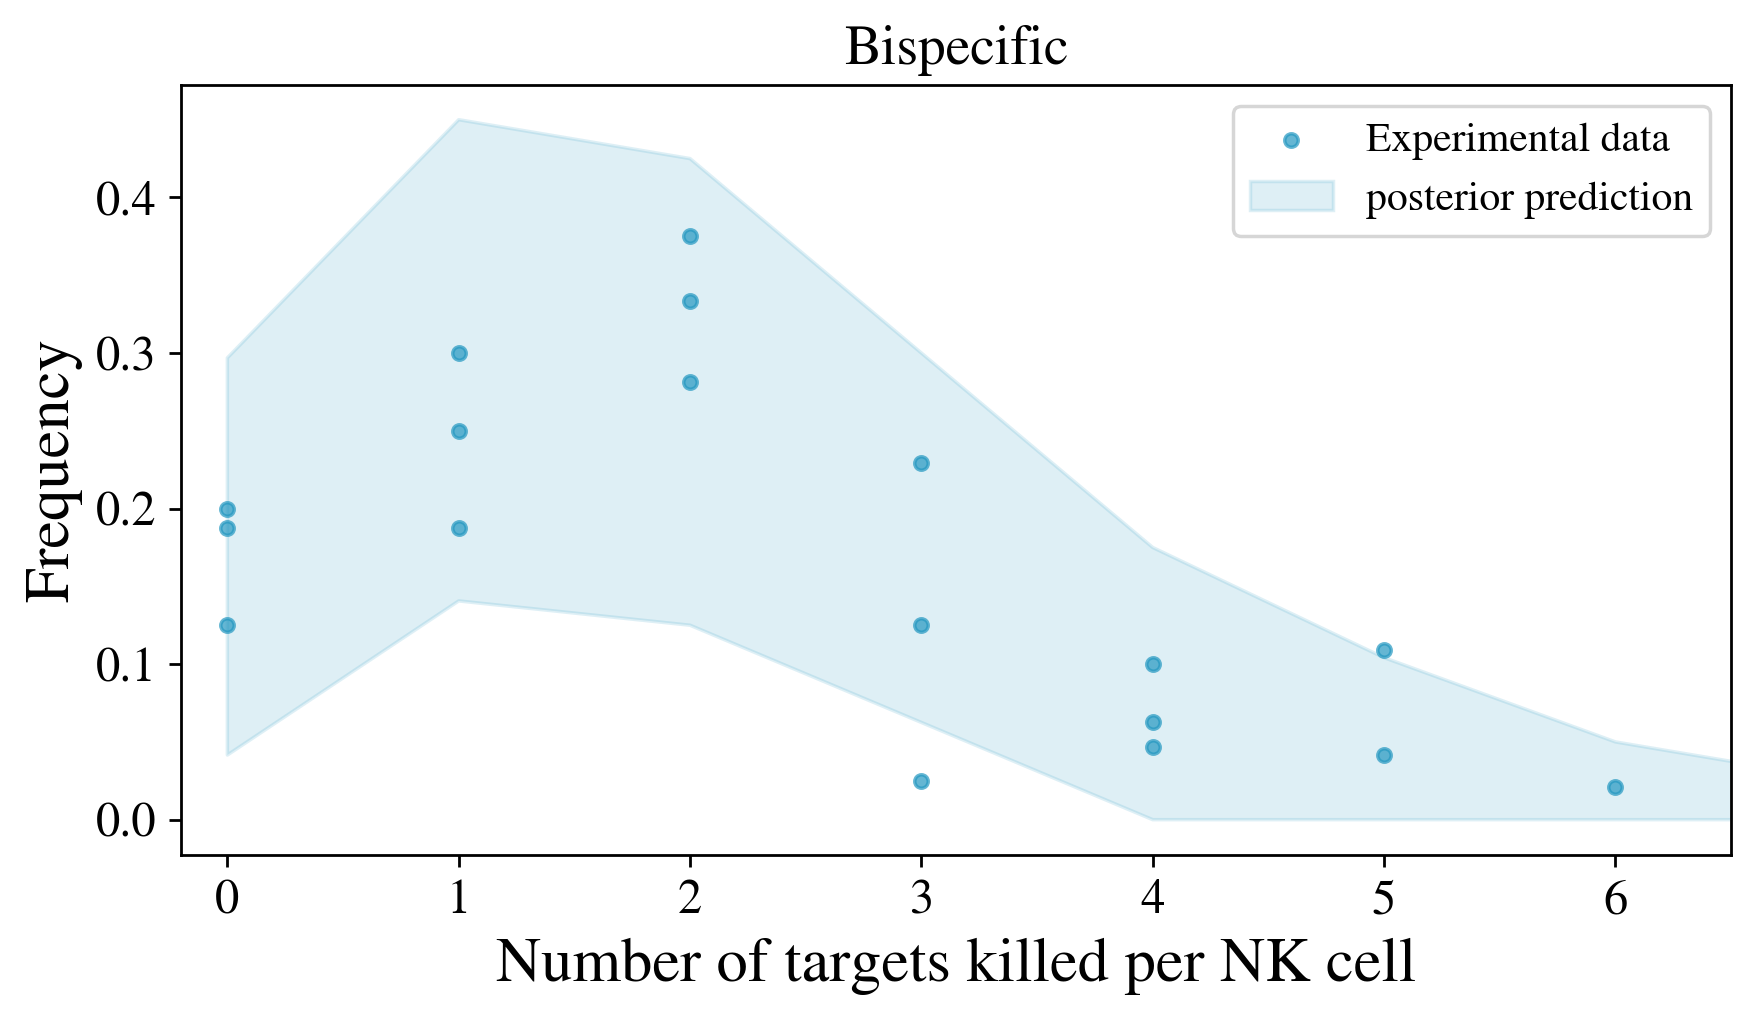

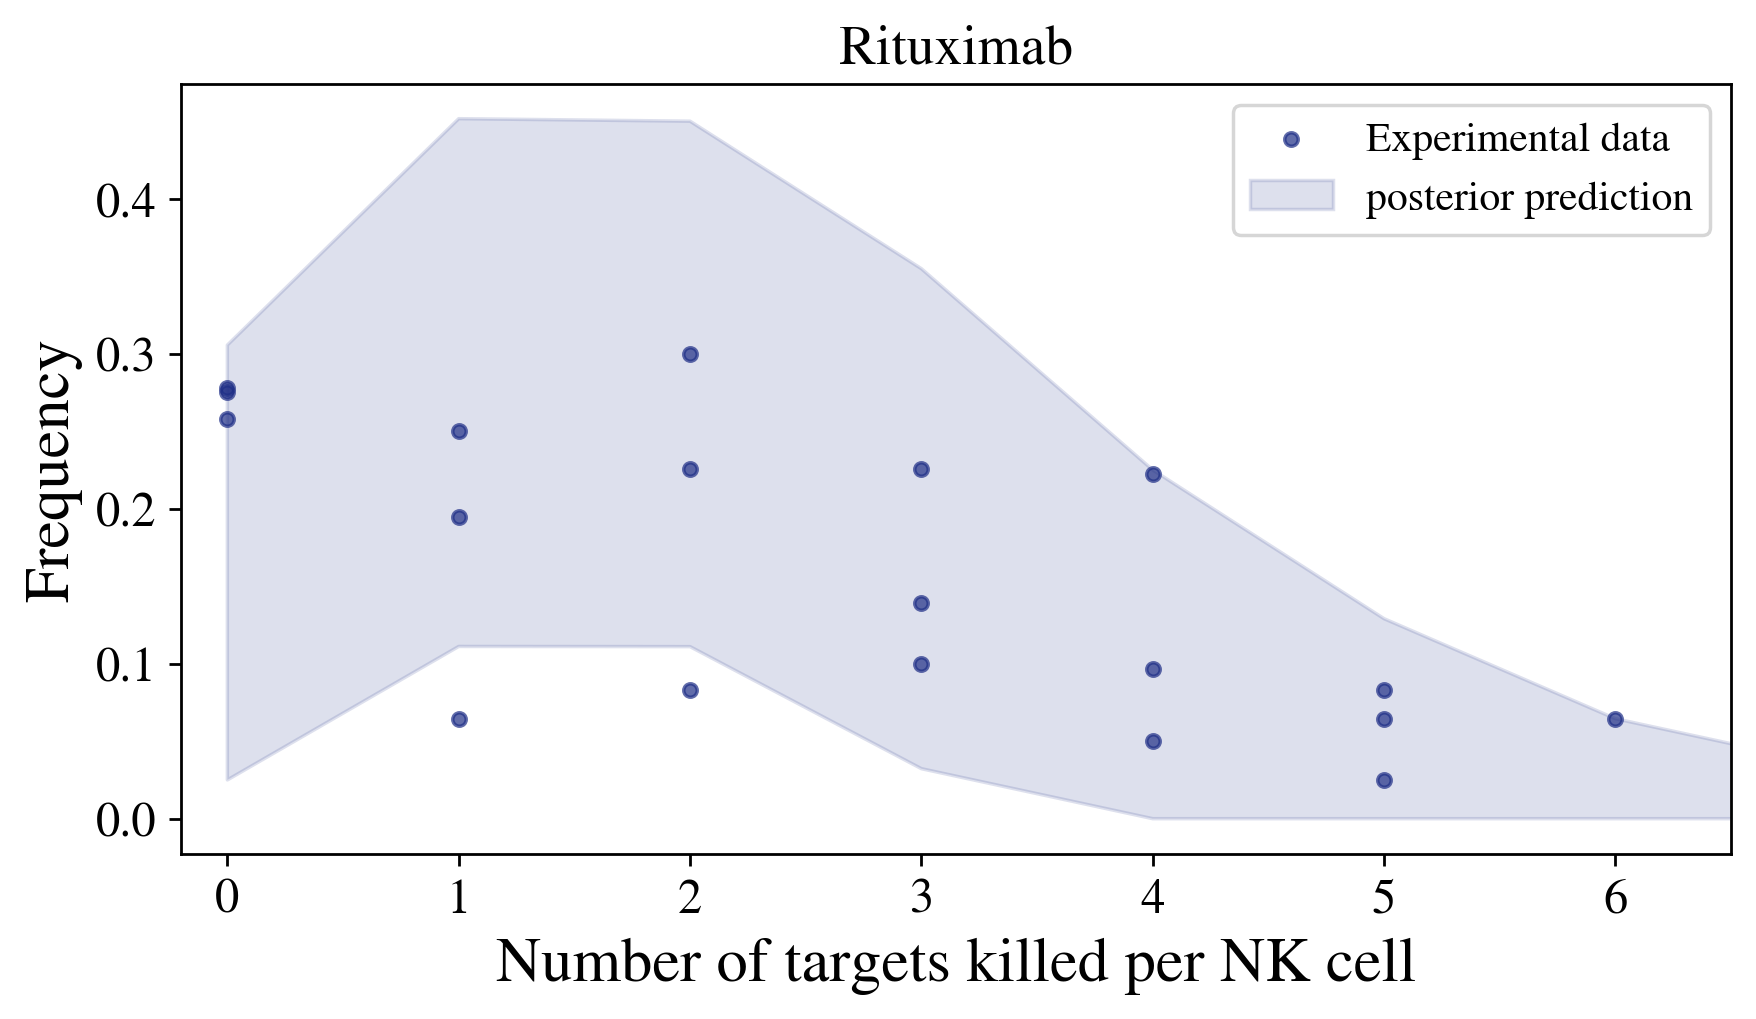

In [21]:
# --- Cell 2: Plotting from Stored Data (merged simulation band, padded arrays, optimized) ---
for group, data in generated_data.items():
    exp_freqs = data['exp_freqs']
    sim_freqs_per_rep = data['sim_freqs_per_rep']
    colour = data['colour']
    maxlen = data['maxlen']
    plt.figure(figsize=(8,4), dpi=250)
    # Plot all experimental replicates as dots
    for rep_idx, freq in enumerate(exp_freqs):
        x_exp = np.arange(len(freq))
        plt.scatter(x_exp, freq, color=colour, alpha=0.7, s=15, label=f'Experimental data' if rep_idx==0 else None)
    # Pad all simulation arrays to the same length before merging
    sim_pad_len = max([sim_matrix.shape[1] for sim_matrix in sim_freqs_per_rep]) if sim_freqs_per_rep else maxlen
    sim_freqs_per_rep_pad = [np.pad(sim_matrix, ((0,0),(0, sim_pad_len - sim_matrix.shape[1])), 'constant') for sim_matrix in sim_freqs_per_rep]
    merged_sim_matrix = np.vstack(sim_freqs_per_rep_pad) if sim_freqs_per_rep_pad else np.empty((0, sim_pad_len))
    # --- OPTIMIZATION: subsample if large, use float32 ---
    if merged_sim_matrix.shape[0] > 2000:
        idx = np.random.choice(merged_sim_matrix.shape[0], 2000, replace=False)
        merged_sim_matrix = merged_sim_matrix[idx]
    merged_sim_matrix = merged_sim_matrix.astype(np.float32)
    # --- OPTIMIZATION: use only 1st and 99th percentiles ---
    percentiles = [1, 99]
    percentile_bands = np.percentile(merged_sim_matrix, percentiles, axis=0) if merged_sim_matrix.size > 0 else np.zeros((2, sim_pad_len))
    x_sim = np.arange(merged_sim_matrix.shape[1]) if merged_sim_matrix.size > 0 else np.arange(sim_pad_len)
    plt.fill_between(
        x_sim, percentile_bands[0], percentile_bands[1], color=colour, alpha=0.15,
        label='posterior prediction'
    )
    plt.xlabel("Number of targets killed per NK cell")
    plt.ylabel("Frequency")
    plt.title(f"{group}")
    max_kill = max(len(freq)-1 for freq in exp_freqs)
    plt.xlim(-0.2, max_kill+0.5)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune=None, nbins=sim_pad_len))
    plt.legend()
    plt.savefig(f"./simulated_vs_experimental_{group.replace(' ','_')}.pdf", dpi=500, bbox_inches="tight")
    plt.show()

In [ ]:
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

for group, data in generated_data.items():
    exp_freqs = data['exp_freqs']
    sim_freqs_per_rep = data['sim_freqs_per_rep']
    colour = data['colour']
    max_kill = max(len(freq) for freq in exp_freqs) - 1
    plt.figure(figsize=(10, 6), dpi=100)
    # Plot experimental replicates as dots
    for rep_idx, freq in enumerate(exp_freqs):
        x_exp = np.arange(len(freq))
        plt.scatter(x_exp, freq, color=colour, alpha=0.9, s=18, label='Experimental data' if rep_idx==0 else None)
    sim_pad_len = max_kill + 1
    sim_freqs_per_rep_fixed = []
    for sim_matrix in sim_freqs_per_rep:
        n_rows, n_cols = sim_matrix.shape
        if n_cols < sim_pad_len:
            pad_width = sim_pad_len - n_cols
            sim_matrix_fixed = np.pad(sim_matrix, ((0,0),(0,pad_width)), 'constant')
        elif n_cols > sim_pad_len:
            sim_matrix_fixed = sim_matrix[:, :sim_pad_len]
        else:
            sim_matrix_fixed = sim_matrix
        sim_freqs_per_rep_fixed.append(sim_matrix_fixed)
    all_sim_freqs = np.vstack(sim_freqs_per_rep_fixed) if sim_freqs_per_rep_fixed else np.empty((0, sim_pad_len))
    # For each kill number, plot smooth violin using KDE
    for k in range(sim_pad_len):
        data_k = all_sim_freqs[:, k] if all_sim_freqs.shape[0] > 0 else np.array([])
        # --- OPTIMIZATION: subsample if large, reduce y_grid resolution ---
        # if len(data_k) > 5000:
        #     data_k = np.random.choice(data_k, 5000, replace=False)
        if len(data_k) > 1:  # KDE needs at least 2 points
            kde = gaussian_kde(data_k, bw_method=0.3)
            y_grid = np.linspace(0, max(data_k.max(), 0.2), 300)  
            density = kde(y_grid)
            # Scale density for visual width
            density = density / density.max() * 0.3
            plt.fill_betweenx(y_grid, k - density, k + density, color=colour, alpha=0.25, edgecolor='black', linewidth=0.7)
            # Optionally, draw median line
            # plt.plot([k], [np.median(data_k)], marker='o', color='black', markersize=4)
    plt.xlabel('Number of targets killed per NK cell')
    plt.ylabel('Frequency')
    plt.title(f'{group}: Experimental dots, posterior prediction as violin')
    plt.xlim(-0.5, max_kill+0.5)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune=None, nbins=sim_pad_len))
    legend_patches = [Patch(facecolor=colour, edgecolor='black', label='Posterior prediction', alpha=0.25)]
    plt.legend(handles=legend_patches + [plt.Line2D([0], [0], marker='o', color='w', label='Experimental data', markerfacecolor=colour, markersize=8)], loc='upper right')
    plt.tight_layout()
    plt.savefig(f'./simulated_vs_experimental_violin_{group.replace(" ","_")}.pdf', dpi=500, bbox_inches='tight')
    plt.show()

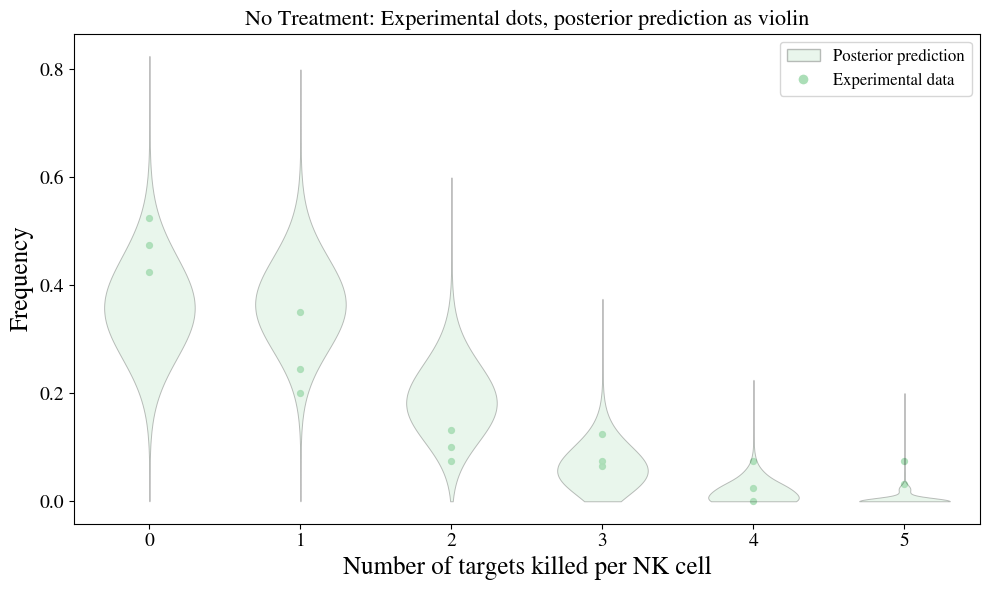

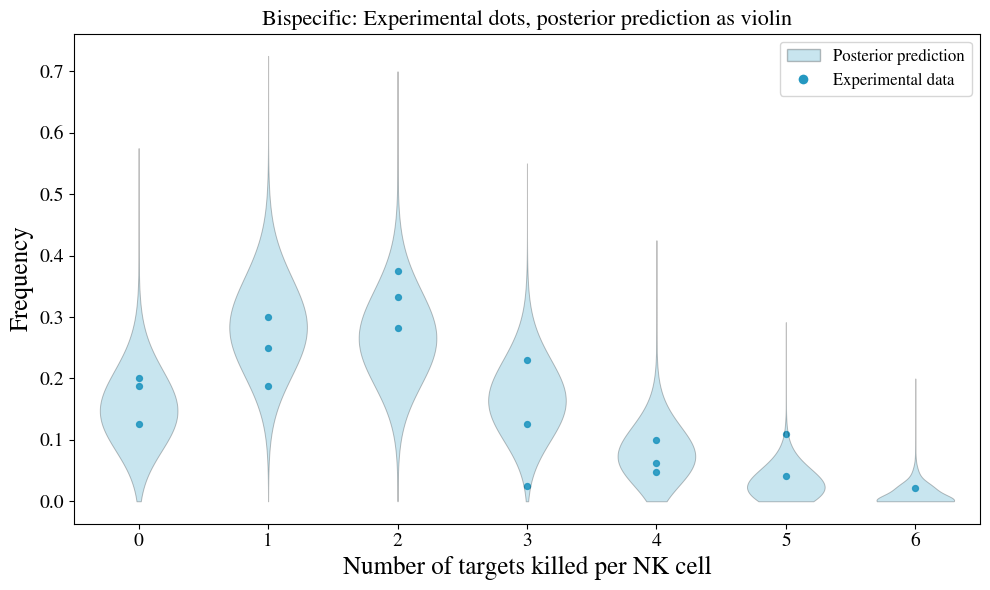

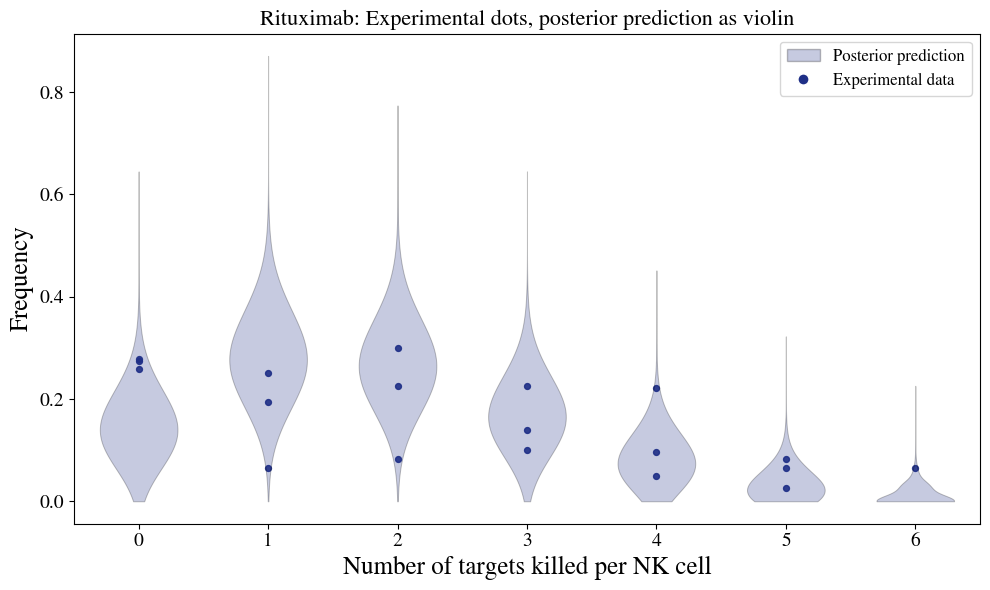

In [9]:
from joblib import Parallel, delayed
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

def compute_kde(data_k, k, colour):
    if len(data_k) > 1:
        kde = gaussian_kde(data_k.astype(np.float32), bw_method=0.7)
        y_grid = np.linspace(0, max(data_k.max(), 0.2), 300)
        density = kde(y_grid)
        density = density / density.max() * 0.3
        return (k, y_grid, density, colour)
    return None

for group, data in generated_data.items():
    exp_freqs = data['exp_freqs']
    sim_freqs_per_rep = data['sim_freqs_per_rep']
    colour = data['colour']
    max_kill = max(len(freq) for freq in exp_freqs) - 1
    plt.figure(figsize=(10, 6), dpi=100)
    for rep_idx, freq in enumerate(exp_freqs):
        x_exp = np.arange(len(freq))
        plt.scatter(x_exp, freq, color=colour, alpha=0.9, s=18, label='Experimental data' if rep_idx==0 else None)
    sim_pad_len = max_kill + 1
    sim_freqs_per_rep_fixed = []
    for sim_matrix in sim_freqs_per_rep:
        n_rows, n_cols = sim_matrix.shape
        if n_cols < sim_pad_len:
            pad_width = sim_pad_len - n_cols
            sim_matrix_fixed = np.pad(sim_matrix, ((0,0),(0,pad_width)), 'constant')
        elif n_cols > sim_pad_len:
            sim_matrix_fixed = sim_matrix[:, :sim_pad_len]
        else:
            sim_matrix_fixed = sim_matrix
        sim_freqs_per_rep_fixed.append(sim_matrix_fixed)
    all_sim_freqs = np.vstack(sim_freqs_per_rep_fixed) if sim_freqs_per_rep_fixed else np.empty((0, sim_pad_len))
    # Parallel KDE computation
    kde_results = Parallel(n_jobs=-1)(
        delayed(compute_kde)(all_sim_freqs[:, k], k, colour) for k in range(sim_pad_len)
    )
    for result in kde_results:
        if result is not None:
            k, y_grid, density, colour = result
            plt.fill_betweenx(y_grid, k - density, k + density, color=colour, alpha=0.25, edgecolor='black', linewidth=0.7)
    plt.xlabel('Number of targets killed per NK cell')
    plt.ylabel('Frequency')
    plt.title(f'{group}: Experimental dots, posterior prediction as violin')
    plt.xlim(-0.5, max_kill+0.5)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune=None, nbins=sim_pad_len))
    legend_patches = [Patch(facecolor=colour, edgecolor='black', label='Posterior prediction', alpha=0.25)]
    plt.legend(handles=legend_patches + [plt.Line2D([0], [0], marker='o', color='w', label='Experimental data', markerfacecolor=colour, markersize=8)], loc='upper right')
    plt.tight_layout()
    plt.savefig(f'./simulated_vs_experimental_violin_{group.replace(" ", "_")}.pdf', dpi=500, bbox_inches='tight')
    plt.show()

```python
cmap = get_cmap('YlGnBu')
colors = cmap(np.linspace(0.3, 0.9, len(conditions)))
conditions = list(KillFreqTable.keys())
replicates = sorted({date for cond in KillFreqTable.values() for date in cond.keys()})

for i, group in enumerate(KillFreqTable):
    plt.figure(figsize=(8,4), dpi = 250)
    colour = colors[i]
    print("Experimental condition: ", group)
    print("replicates: ", list(KillFreqTable[group].keys()))
    posterior_rate_list = idatas[i][1].posterior['r'].values.flatten()
    print("Posterior rates: ", posterior_rate_list)
    
    # Experiments
    T_N_cells = 0
    exp_freqs = []
    for rep in KillFreqTable[group]:
        # Experimental Data
        arr = KillFreqTable[group][rep]
        n_cells = arr.size
        T_N_cells += n_cells
        counts = np.bincount(arr, minlength=int(arr.max())+1)
        freq = counts / n_cells if n_cells > 0 else np.zeros_like(counts)
        x = np.arange(len(freq))
        plt.scatter(x, freq, color=colour, alpha=0.7, s = 15)
        exp_freqs.append(freq)
    print("total cell number: ", T_N_cells)
    maxlen = max(len(f) for f in exp_freqs)
    
    
    #Simulation
    each_condition_freqs_union = []
    for posterior_rate in posterior_rate_list:
        simulation = experiment(
            killing_rate = posterior_rate,
            Duration  = T_Total,
            Killer_cell_number = T_N_cells,
            # Killer_cell_number =  200,
            replicate = 1000
            )
        each_rate_freq_union = []
        for shit in simulation:
            shit_count = np.bincount(shit)
            shit_freq = shit_count/shit.size
            each_rate_freq_union.append(shit_freq)
        each_condition_freqs_union.append(each_rate_freq_union)
    all_freq_arrays = [freq for rate_freqs in each_condition_freqs_union for freq in rate_freqs]
    maxlen = max(len(f) for f in all_freq_arrays)
    all_freq_arrays_pad = [np.pad(f, (0, maxlen - len(f)), 'constant') for f in all_freq_arrays]
    freq_matrix = np.vstack(all_freq_arrays_pad)
    percentiles = np.arange(0.01, 99.99)
    percentile_bands = np.percentile(freq_matrix, percentiles, axis=0)
    x = np.arange(freq_matrix.shape[1])
    plt.fill_between(
        x, percentile_bands[0], percentile_bands[-1], color=colour, alpha=0.15,
        label='1st-99th percentile'
        )
    
    
    plt.xlabel("Number of targets killed per NK cell")
    plt.ylabel("Frequency")
    plt.title(f"{group}")
    max_kill = max(arr.max() if arr.size > 0 else 0 for arr in KillFreqTable[group].values())
    plt.xlim(-0.5, max_kill+0.5)
    # plt.xticks(x_pad, rotation=45)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune=None, nbins=maxlen))
    plt.legend()
    # plt.grid(True)
    plt.show()
```

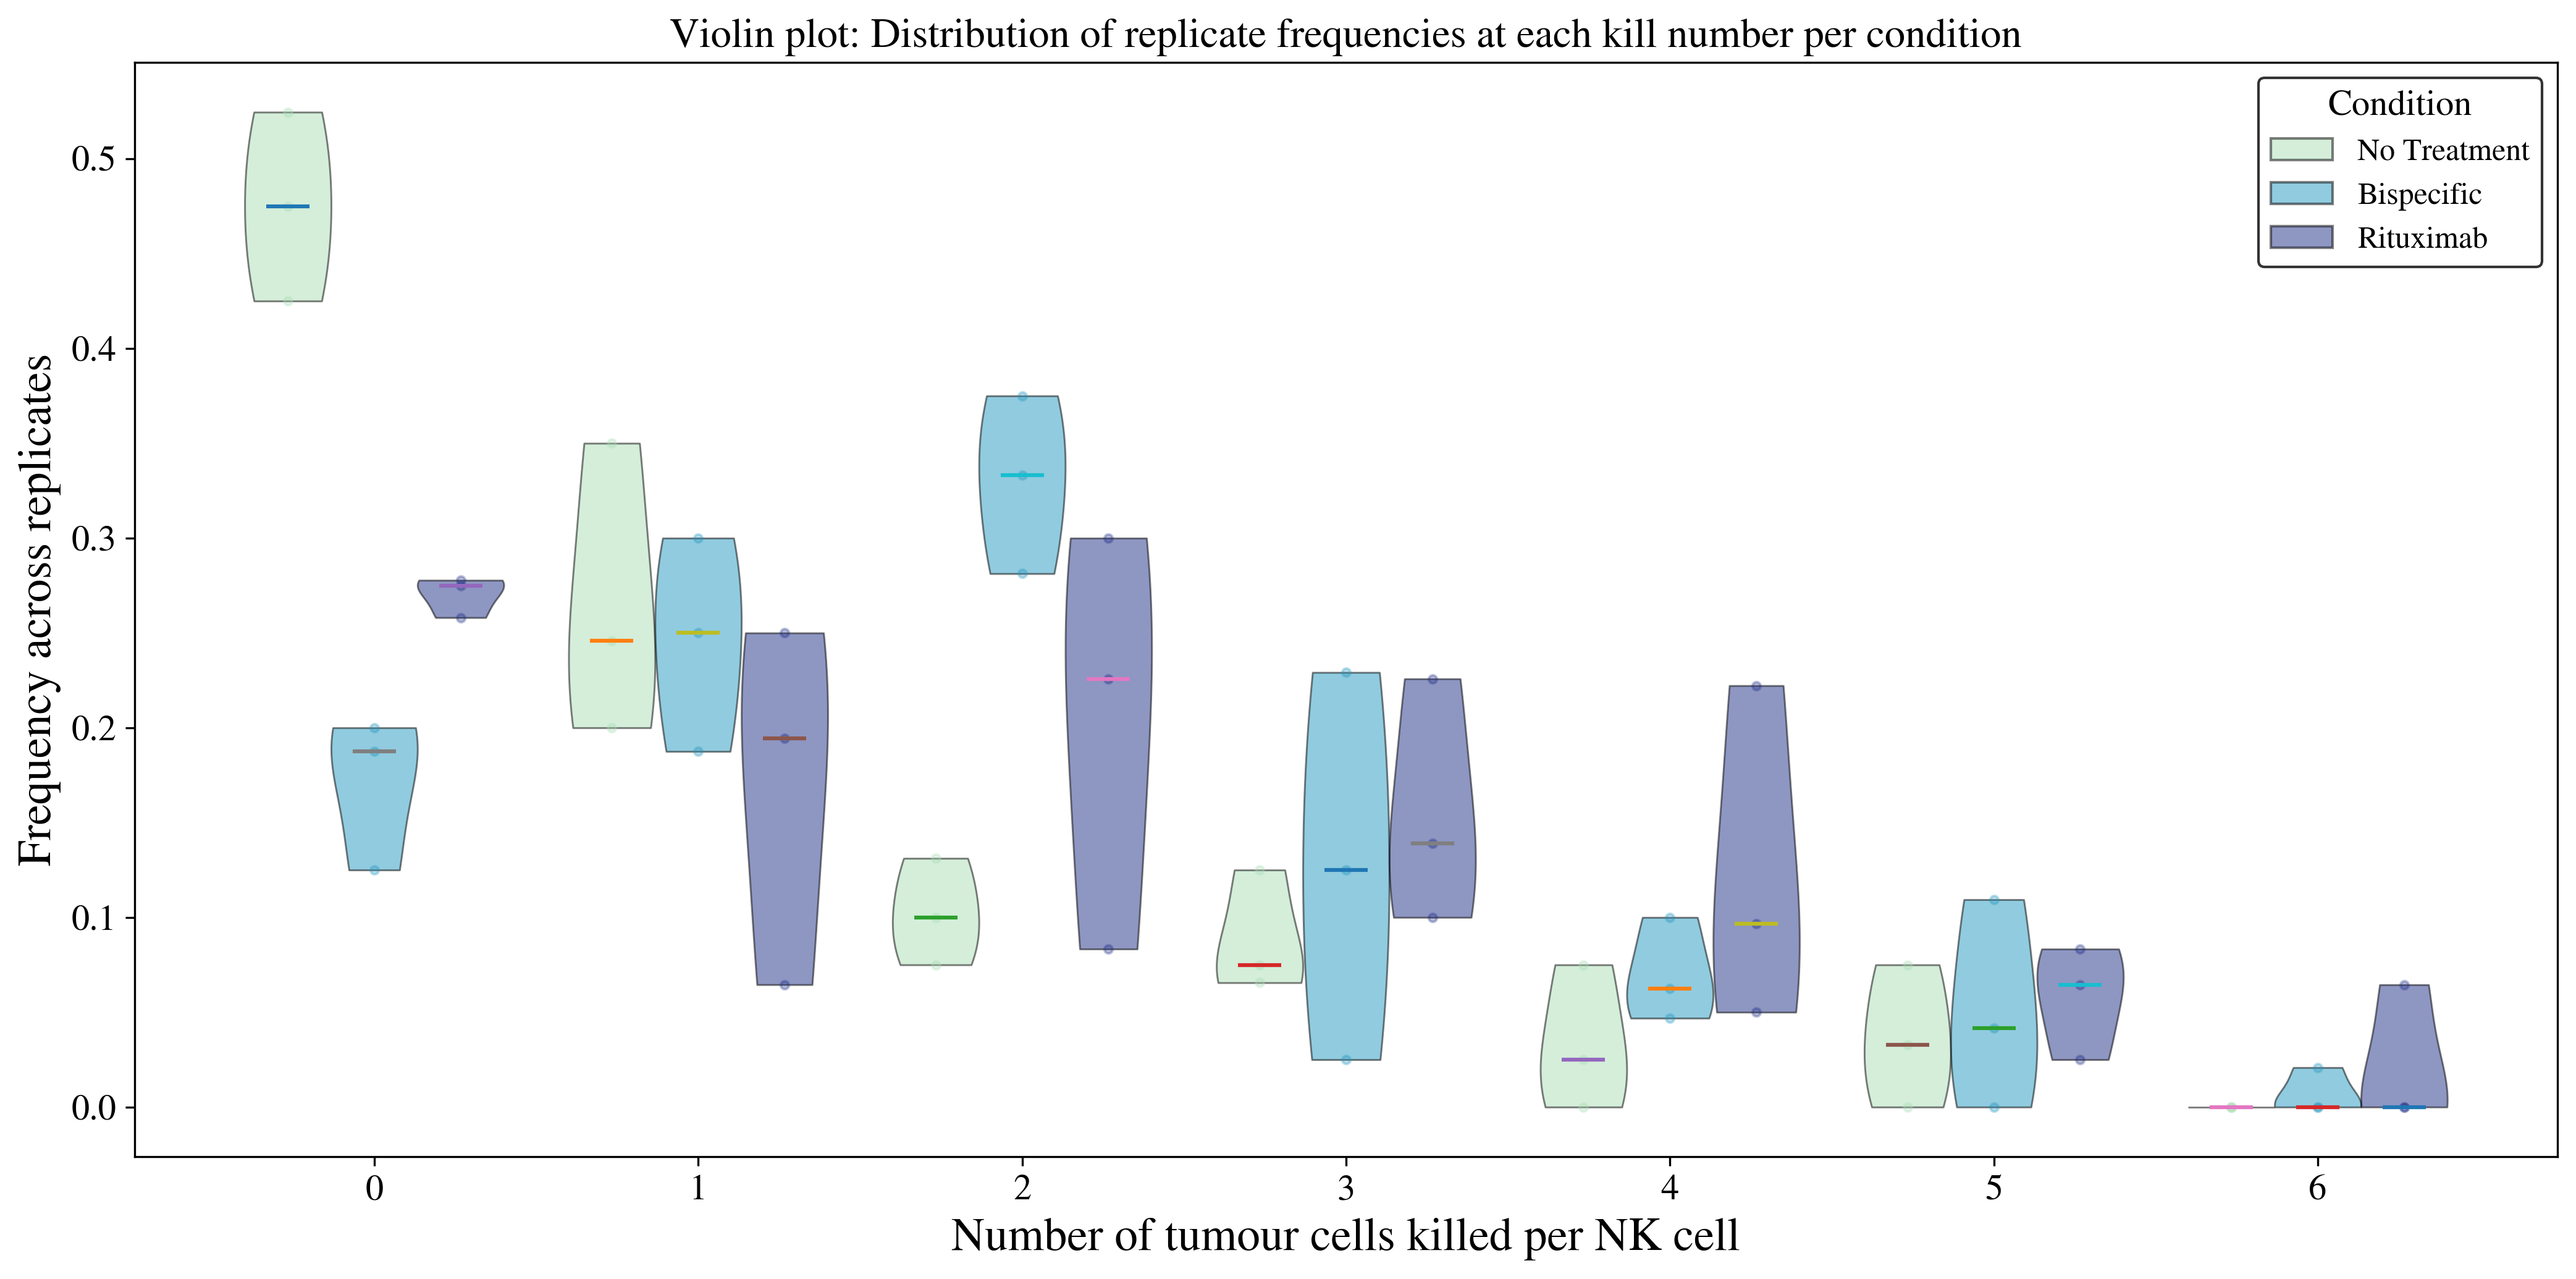

In [21]:
# Violin plot: For each condition, at each kill number, show the distribution of replicate frequencies
import matplotlib.pyplot as plt
import numpy as np

conditions = list(KillFreqTable.keys())
dates = sorted({date for cond in KillFreqTable.values() for date in cond.keys()})
cmap = plt.cm.YlGnBu
colors = cmap(np.linspace(0.3, 0.9, len(conditions)))

max_kill = 0
for cond in conditions:
    for date in KillFreqTable[cond]:
        arr = KillFreqTable[cond][date]
        if arr.size > 0:
            max_kill = max(max_kill, arr.max())

fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

# For each condition, collect replicate frequencies for each kill number
width = 0.8 / len(conditions)  # width per violin
for idx, cond in enumerate(conditions):
    # For each replicate, get frequency for each kill number
    replicate_freqs = []  # list of arrays, each array: freq per kill number for one replicate
    for date in KillFreqTable[cond]:
        arr = KillFreqTable[cond][date]
        n_cells = arr.size
        counts = np.bincount(arr, minlength=max_kill+1)
        freq = counts / n_cells if n_cells > 0 else np.zeros(max_kill+1)
        replicate_freqs.append(freq)
    replicate_freqs = np.array(replicate_freqs)  # shape: (n_replicates, max_kill+1)

    # For each kill number, collect the distribution of frequencies across replicates
    for k in range(max_kill+1):
        data = replicate_freqs[:, k]  # frequencies for kill number k across replicates
        pos = k + idx * width - 0.4 + width/2  # offset for condition
        parts = ax.violinplot(data, positions=[pos], widths=width, showmeans=False, showmedians=True, showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(colors[idx])
            pc.set_alpha(0.5)
            pc.set_edgecolor('black')
            pc.set_linewidth(0.7)
        # Overlay individual points
        ax.scatter([pos]*len(data), data, color=colors[idx], alpha=0.3, s=10)

# X-ticks: kill numbers
xtick_positions = np.arange(max_kill+1)
ax.set_xticks(xtick_positions)
ax.set_xticklabels([str(k) for k in xtick_positions])
ax.set_xlabel('Number of tumour cells killed per NK cell')
ax.set_ylabel('Frequency across replicates')
ax.set_title('Violin plot: Distribution of replicate frequencies at each kill number per condition')

# Legend for conditions
from matplotlib.patches import Patch
legend_patches = [Patch(facecolor=colors[i], edgecolor='black', label=cond, alpha=0.5) for i, cond in enumerate(conditions)]
ax.legend(handles=legend_patches, title='Condition', frameon=True, edgecolor='black', loc='upper right')

plt.tight_layout()
plt.savefig('./experimental_data_violinplot_per_killnumber_per_condition.pdf', dpi=500, bbox_inches='tight')
plt.show()

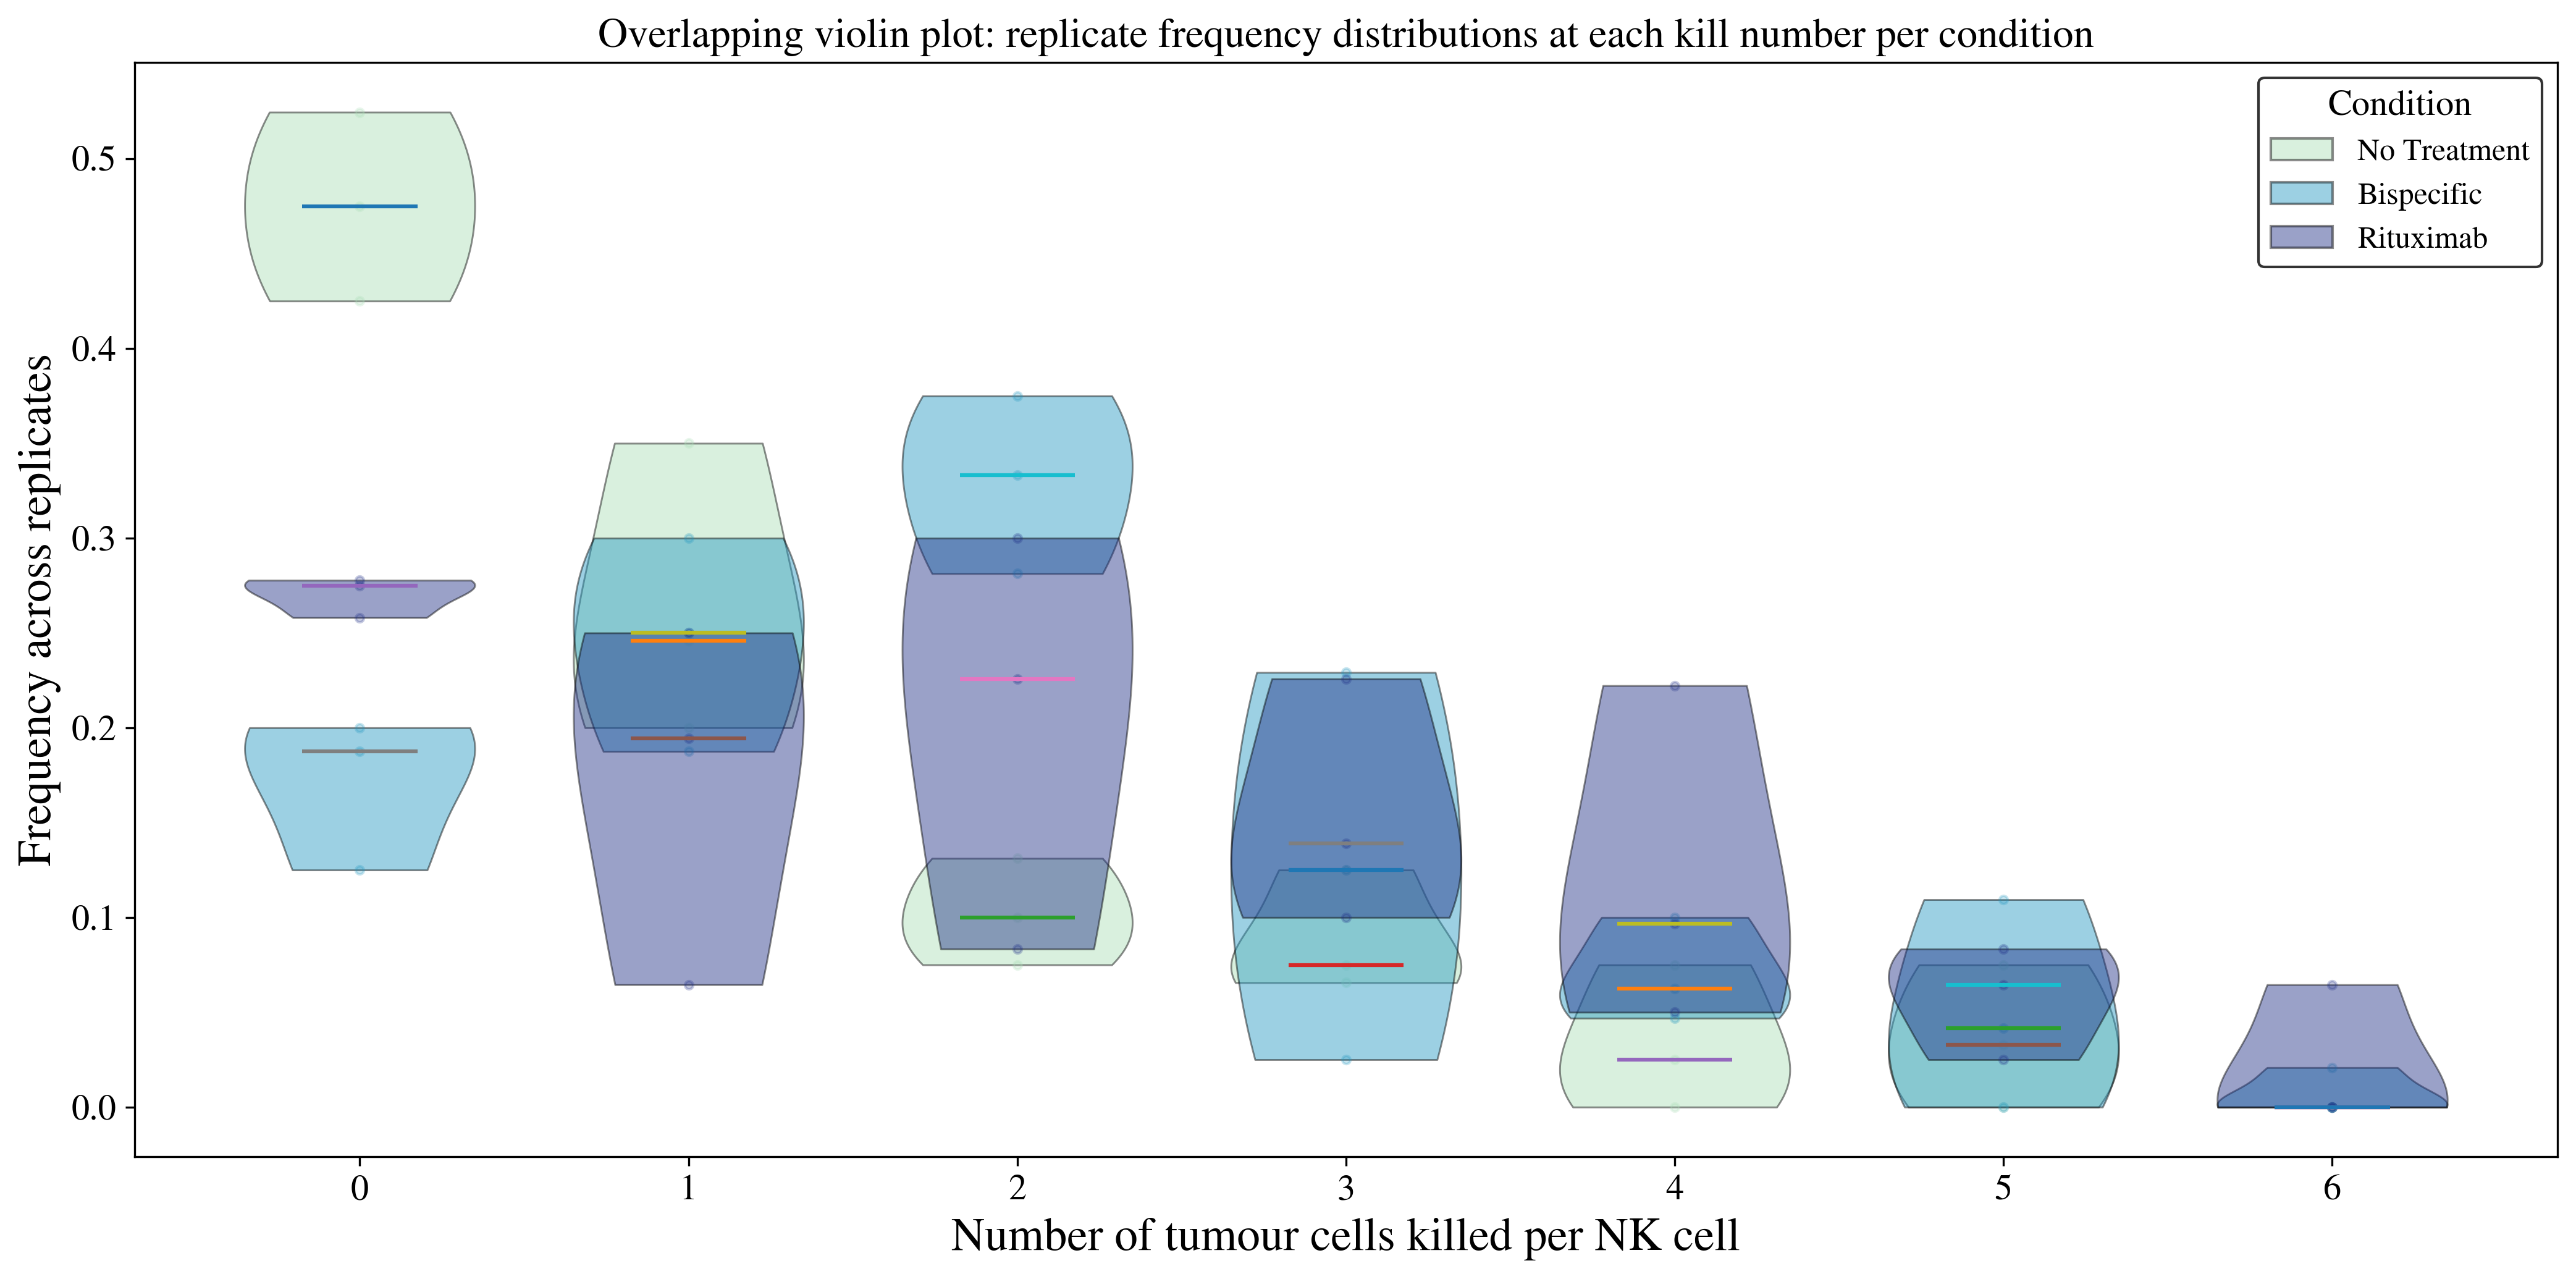

In [22]:
# Overlapping violin plots: For each kill number, overlay all conditions' replicate frequency distributions
import matplotlib.pyplot as plt
import numpy as np

conditions = list(KillFreqTable.keys())
cmap = plt.cm.YlGnBu
colors = cmap(np.linspace(0.3, 0.9, len(conditions)))

# Find the maximum kill number across all conditions/replicates
max_kill = 0
for cond in conditions:
    for date in KillFreqTable[cond]:
        arr = KillFreqTable[cond][date]
        if arr.size > 0:
            max_kill = max(max_kill, arr.max())

fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

for idx, cond in enumerate(conditions):
    # Collect replicate frequencies for each kill number
    replicate_freqs = []
    for date in KillFreqTable[cond]:
        arr = KillFreqTable[cond][date]
        n_cells = arr.size
        counts = np.bincount(arr, minlength=max_kill+1)
        freq = counts / n_cells if n_cells > 0 else np.zeros(max_kill+1)
        replicate_freqs.append(freq)
    replicate_freqs = np.array(replicate_freqs)  # shape: (n_replicates, max_kill+1)

    # For each kill number, plot the violin at the same position (kill number)
    for k in range(max_kill+1):
        data = replicate_freqs[:, k]
        parts = ax.violinplot(data, positions=[k], widths=0.7, showmeans=False, showmedians=True, showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(colors[idx])
            pc.set_alpha(0.45)
            pc.set_edgecolor('black')
            pc.set_linewidth(0.7)
        # Overlay individual points
        ax.scatter([k]*len(data), data, color=colors[idx], alpha=0.25, s=10)

# X-ticks: kill numbers
xtick_positions = np.arange(max_kill+1)
ax.set_xticks(xtick_positions)
ax.set_xticklabels([str(k) for k in xtick_positions])
ax.set_xlabel('Number of tumour cells killed per NK cell')
ax.set_ylabel('Frequency across replicates')
ax.set_title('Overlapping violin plot: replicate frequency distributions at each kill number per condition')

# Legend for conditions
from matplotlib.patches import Patch
legend_patches = [Patch(facecolor=colors[i], edgecolor='black', label=cond, alpha=0.45) for i, cond in enumerate(conditions)]
ax.legend(handles=legend_patches, title='Condition', frameon=True, edgecolor='black', loc='upper right')

plt.tight_layout()
plt.savefig('./experimental_data_violinplot_per_killnumber_per_condition_OVERLAP.pdf', dpi=500, bbox_inches='tight')
plt.show()